### Hourly

 ---

### Import

Reload

In [1]:
%load_ext autoreload
%autoreload 2

##### Installed

In [2]:
# base
import time
import sys, os

In [3]:
# processing
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
# import gym
import ta
# import tsfresh as tsf
# from sklearn.calibration import CalibratedClassifierCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import StandardScaler
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.neural_network import MLPClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
# from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [4]:
# connecting
from binance.client import Client
from s3fs.core import S3FileSystem

In [5]:
# d(r)L
import tensorflow as tf

from stable_baselines import PPO2, DQN, A2C
from stable_baselines.common.evaluation import evaluate_policy
from stable_baselines.common.env_checker import check_env
from stable_baselines.common.callbacks import EvalCallback
from stable_baselines.common import make_vec_env

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [6]:
init_notebook_mode(connected=True)

##### Local

In [7]:
sys.path.append(os.path.dirname(os.getcwd()))

In [8]:
from cryptoast.utils.misc import list_devices
from cryptoast.utils.cred import Cred
from cryptoast.base.kline import Kline, _Kline, Indicators, _Indicators, Signals, _Signals
from cryptoast.base.klines import Klines, KLMngr
from cryptoast.model.agents import Backtest , SingleAssetEnv

##### Functions

In [9]:
def get_weights(size, method='linear', *args):
    if method in ['linear', 'lin']:
        return np.arange(1, size+1)
    elif method in ['exponential', 'exp']:
        a, b = args
        return a**np.linspace(0, b, size)
    return np.ones(size)

### Initialization

In [10]:
cred = Cred()

In [11]:
bases = ['BTC', 'ETH', 'ADA', 'DOT', 'XRP', 'UNI', 'LTC', 'LINK', 'BCH', 'XLM', 'VET', 'IOTA', 'TRX', 'AAVE', 'ATOM', 'EOS', 'AVAX', 'XEM', 'XTZ', 'BTT', 'NEO', 'ALGO', 'CHZ', 'DASH', 'SNX', 'MKR', 'COMP', 'BAT', 'ZEC', 'ETC', 'UMA', 'WAVES', 'YFI', 'ZRX', 'ONT', 'REN', 'DGB', 'OMG', 'QTUM', 'LSK', 'OCEAN', 'KNC', 'REP', 'BAND', 'KMD', 'ANT', 'DOGE', 'ENJ', 'LTO', 'THETA']

In [12]:
quotes_or_assets = []
quotes_or_assets += [_+'USDT' for _ in bases]
# quotes_or_assets += [_+'BTC' for _ in bases if _ != 'BTC']

In [13]:
root_path = 'admin-invest/'
data_path = root_path+'data/'
store_indicators = None #[_ for _ in Kline._store_indicators_default if _[0] not in ('obv')]
store_signals = None
# store_signals = [
#     ('crossovers', ('sma_50', 'sma_200')),
#     ('trend', ('sma_50', 2)),
#     ('pricecross', ('sma_50',)),
#     ('macdcross', (12, 26)),
#     ('rsicross', (14, 30, 70)),
#     ('rsicross2', ())
# ]

In [14]:
# Remote filesystem - No exchange client

iam_key, iam_secret = cred.get('IAM')
s3 = S3FileSystem(anon=False, key=iam_key, secret=iam_secret)
url_scheme = s3.open

client = Client("a","b")

klmngr = KLMngr(quotes_or_assets=quotes_or_assets, client=client, url_scheme=url_scheme, root_path=root_path,
                store_indicators=store_indicators, store_signals=store_signals)

### Update

In [ ]:
print(datetime.utcnow().replace(microsecond=0))

In [ ]:
klmngr.info.reindex(quotes_or_assets).last_update.min()

In [ ]:
klmngr.update(verbose=2)

In [ ]:
klmngr.info.reindex(quotes_or_assets).last_update.min()

### Preprocessing

##### Artificial USDT

### Baseline

Single asset

In [20]:
kline = klmngr['ETHUSDT'] # klmngr[klmngr.assets[1]]
print(kline.asset)

ETHUSDT


In [41]:
index = kline.index[:-1].to_frame().rename(columns={0: 'datetime'})
index = index.assign(index=index.datetime.dt.date)
_sigs = kline.signals.eq(1).mean(axis=1).shift(1).values[:-1]
# _sigs = kline.signals.eq(1).mean(axis=1).rolling(6).mean().shift(1).values[:-1]
# sigs = np.where(_sigs <= -.6, -1, np.where(_sigs >= .8, 1, 0))
sigs = np.where(_sigs < .3, -1, np.where(_sigs >= .8, 1, 0))

In [42]:
btst = Backtest(kline, start_index=0, init_assets=1, commission=0.001, slippage_pct=0.1, slippage_steps=0)
btst.run(999*sigs, verbose=0)

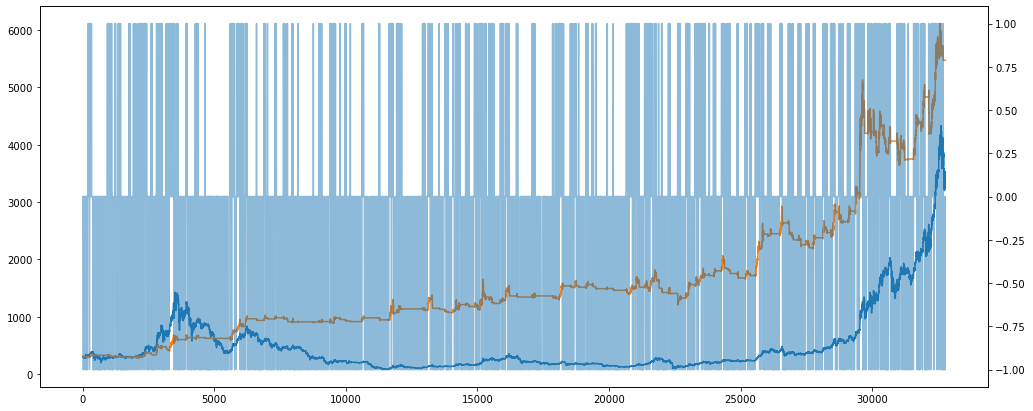

In [52]:
fig, ax = plt.subplots(figsize=(17, 7))
ax.plot(kline.close.values)
ax.plot(btst.periodic.value.values)
ax2 = ax.twinx()
ax2.plot(sigs, alpha=.5)

### Model test 2: RF

##### Manual reloads

In [ ]:
from cryptoast.model.agents import SingleAssetEnv

In [ ]:
from stable_baselines.common.policies import FeedForwardPolicy, register_policy
from stable_baselines.deepq.policies import FeedForwardPolicy as DQNFFP

##### Check for uniform shape within indicators

In [16]:
bad_assets = [asset for asset in klmngr.assets if klmngr[asset].indicators.columns.size != 34]
print(bad_assets)

[]


##### Discrete action, Single Process

Define assets

In [20]:
test_assets = ['ETHUSDT']

In [21]:
train_assets = list(set(klmngr.assets)-set(test_assets)-set(bad_assets))

Testing ground

In [149]:
asset = np.random.choice(klmngr.assets) # 'BTCUSDT'
btst = Backtest(kline=klmngr[asset])
env = SingleAssetEnv(klmngr, assets=train_assets, backtest=btst, window=24, )

1


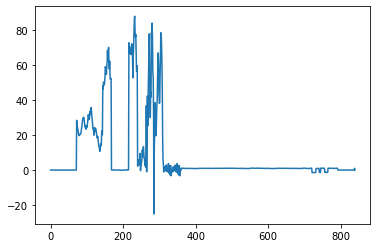

In [150]:
obs = env.step(np.random.choice([0, 1, 2]))[0]
print(env.current_step)
plt.plot(obs)

In [151]:
obs = env.reset()

0.0


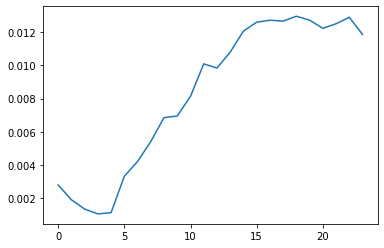

In [158]:
obs, reward, _, __ = env.step(2)
plt.plot(obs[:24])
print(reward)

DQN

In [ ]:
# Custom MLP policy of three layers of size 128 each
class CustomDQNPolicy(DQNFFP):
    def __init__(self, *args, **kwargs):
        super(CustomDQNPolicy, self).__init__(*args, **kwargs,
                                           layers=[64, 64, 64, 64],
                                           layer_norm=True,
                                           feature_extraction="mlp")

In [22]:
window = 24*2
btst = Backtest(init_assets=0, init_cash=1000, commission=0.001, slippage_pct=0, slippage_steps=0, memory=window)
env_kwargs = dict(klmngr=klmngr,
                  assets=train_assets,
                  backtest=btst,
                  window=window,
                  datetimes=pd.Timestamp(2020, 1, 1),
                  randomize_start=True,
                  allow_gaps=False,
                  episode_steps=24*30*2)
env = SingleAssetEnv(**env_kwargs)
env = make_vec_env(lambda: env, n_envs=1)

In [25]:
eval_callback = EvalCallback(env, 
                             best_model_save_path='../models/h5/',
                             log_path='../models/logs/',
                             eval_freq=500,
                             deterministic=True, 
                             render=False)

In [27]:
total_timesteps = 500*1000
tensorboard_log = '../models/logs_tensorboard/' # None
# model = DQN(policy='MlpPolicy', env=env, exploration_fraction=.2, learning_rate=0.0001, buffer_size=1000000, learning_starts=50000, train_freq=1, prioritized_replay=True, verbose=1, tensorboard_log=tensorboard_log)
# model = DQN(policy=CustomDQNPolicy, env=env, learning_rate=0.0001, buffer_size=1000000, learning_starts=50000, train_freq=1, prioritized_replay=True, verbose=1)

# model = DQN(policy=CustomDQNPolicy, env=env, learning_rate=0.0001, buffer_size=1000000, learning_starts=50000, train_freq=1, prioritized_replay=True, tensorboard_log='C:/Users/guill/Documents/Code/crypto-invest/models/logs', verbose=1)
model = PPO2(policy='MlpPolicy', env=env, verbose=1, tensorboard_log=tensorboard_log)
# model = A2C(policy='MlpPolicy', env=env, verbose=1)

In [28]:
# model.learn(total_timesteps)
model.learn(total_timesteps, callback=eval_callback)

--------------------------------------
| approxkl           | 0.00020048078 |
| clipfrac           | 0.0           |
| explained_variance | 0.0256        |
| fps                | 156           |
| n_updates          | 1             |
| policy_entropy     | 1.0983657     |
| policy_loss        | -0.0032904004 |
| serial_timesteps   | 128           |
| time_elapsed       | 0             |
| total_timesteps    | 128           |
| value_loss         | 56.69925      |
--------------------------------------
---------------------------------------
| approxkl           | 4.580315e-05   |
| clipfrac           | 0.0            |
| explained_variance | -0.001         |
| fps                | 242            |
| n_updates          | 2              |
| policy_entropy     | 1.0977087      |
| policy_loss        | -0.00090141967 |
| serial_timesteps   | 256            |
| time_elapsed       | 0.816          |
| total_timesteps    | 256            |
| value_loss         | 687.7074       |
-------------

--------------------------------------
| approxkl           | 8.562048e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 291           |
| ep_reward_mean     | -190          |
| explained_variance | 0.0513        |
| fps                | 93            |
| n_updates          | 15            |
| policy_entropy     | 1.0916245     |
| policy_loss        | -0.0015488706 |
| serial_timesteps   | 1920          |
| time_elapsed       | 92.4          |
| total_timesteps    | 1920          |
| value_loss         | 156.10469     |
--------------------------------------
Eval num_timesteps=2000, episode_reward=67.47 +/- 84.16
Episode length: 892.20 +/- 452.36
--------------------------------------
| approxkl           | 5.1637286e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 291           |
| ep_reward_mean     | -190          |
| explained_variance | 0.081         |
| fps                | 5             |
| n_updates          | 16            |
| policy_entr

-------------------------------------
| approxkl           | 0.0005063409 |
| clipfrac           | 0.0          |
| ep_len_mean        | 246          |
| ep_reward_mean     | -117         |
| explained_variance | 0.159        |
| fps                | 132          |
| n_updates          | 29           |
| policy_entropy     | 1.0896516    |
| policy_loss        | -0.007938817 |
| serial_timesteps   | 3712         |
| time_elapsed       | 198          |
| total_timesteps    | 3712         |
| value_loss         | 784.5122     |
-------------------------------------
--------------------------------------
| approxkl           | 0.00027404475 |
| clipfrac           | 0.0           |
| ep_len_mean        | 246           |
| ep_reward_mean     | -117          |
| explained_variance | 0.154         |
| fps                | 144           |
| n_updates          | 30            |
| policy_entropy     | 1.0930245     |
| policy_loss        | -0.0028264658 |
| serial_timesteps   | 3840          |
|

Eval num_timesteps=5500, episode_reward=361.58 +/- 617.25
Episode length: 582.40 +/- 264.00
New best mean reward!
-------------------------------------
| approxkl           | 0.0001049391 |
| clipfrac           | 0.0          |
| ep_len_mean        | 298          |
| ep_reward_mean     | -99.1        |
| explained_variance | 0.0921       |
| fps                | 8            |
| n_updates          | 43           |
| policy_entropy     | 1.0892313    |
| policy_loss        | -0.001919343 |
| serial_timesteps   | 5504         |
| time_elapsed       | 286          |
| total_timesteps    | 5504         |
| value_loss         | 326.42474    |
-------------------------------------
--------------------------------------
| approxkl           | 0.00017812934 |
| clipfrac           | 0.0           |
| ep_len_mean        | 298           |
| ep_reward_mean     | -99.1         |
| explained_variance | 0.248         |
| fps                | 130           |
| n_updates          | 44            |
| po

--------------------------------------
| approxkl           | 0.0002785987  |
| clipfrac           | 0.0           |
| ep_len_mean        | 316           |
| ep_reward_mean     | -92           |
| explained_variance | 0.356         |
| fps                | 151           |
| n_updates          | 57            |
| policy_entropy     | 1.0787991     |
| policy_loss        | -0.0065428307 |
| serial_timesteps   | 7296          |
| time_elapsed       | 363           |
| total_timesteps    | 7296          |
| value_loss         | 95.34409      |
--------------------------------------
-------------------------------------
| approxkl           | 0.002156435  |
| clipfrac           | 0.01171875   |
| ep_len_mean        | 316          |
| ep_reward_mean     | -92          |
| explained_variance | 0.101        |
| fps                | 149          |
| n_updates          | 58           |
| policy_entropy     | 1.0735251    |
| policy_loss        | -0.015401711 |
| serial_timesteps   | 7424        

Eval num_timesteps=9000, episode_reward=384.46 +/- 377.78
Episode length: 853.00 +/- 394.81
--------------------------------------
| approxkl           | 0.0004606009  |
| clipfrac           | 0.0           |
| ep_len_mean        | 316           |
| ep_reward_mean     | -89.1         |
| explained_variance | 0.261         |
| fps                | 5             |
| n_updates          | 71            |
| policy_entropy     | 1.0766832     |
| policy_loss        | -0.0074369656 |
| serial_timesteps   | 9088          |
| time_elapsed       | 440           |
| total_timesteps    | 9088          |
| value_loss         | 67.01042      |
--------------------------------------
-------------------------------------
| approxkl           | 0.0015471095 |
| clipfrac           | 0.0078125    |
| ep_len_mean        | 316          |
| ep_reward_mean     | -89.1        |
| explained_variance | 0.38         |
| fps                | 212          |
| n_updates          | 72           |
| policy_entropy   

--------------------------------------
| approxkl           | 0.00024311776 |
| clipfrac           | 0.0           |
| ep_len_mean        | 316           |
| ep_reward_mean     | -89.1         |
| explained_variance | 0.511         |
| fps                | 205           |
| n_updates          | 85            |
| policy_entropy     | 1.054703      |
| policy_loss        | -0.0037949681 |
| serial_timesteps   | 10880         |
| time_elapsed       | 502           |
| total_timesteps    | 10880         |
| value_loss         | 106.42886     |
--------------------------------------
Eval num_timesteps=11000, episode_reward=1052.54 +/- 763.22
Episode length: 940.20 +/- 379.96
New best mean reward!
-------------------------------------
| approxkl           | 0.0013786352 |
| clipfrac           | 0.005859375  |
| ep_len_mean        | 316          |
| ep_reward_mean     | -89.1        |
| explained_variance | 0.336        |
| fps                | 5            |
| n_updates          | 86        

--------------------------------------
| approxkl           | 0.0011990005  |
| clipfrac           | 0.001953125   |
| ep_len_mean        | 306           |
| ep_reward_mean     | -78.4         |
| explained_variance | 0.51          |
| fps                | 149           |
| n_updates          | 99            |
| policy_entropy     | 1.050095      |
| policy_loss        | -0.0077058855 |
| serial_timesteps   | 12672         |
| time_elapsed       | 624           |
| total_timesteps    | 12672         |
| value_loss         | 138.85144     |
--------------------------------------
-------------------------------------
| approxkl           | 0.0010836977 |
| clipfrac           | 0.009765625  |
| ep_len_mean        | 306          |
| ep_reward_mean     | -78.4        |
| explained_variance | 0.522        |
| fps                | 140          |
| n_updates          | 100          |
| policy_entropy     | 1.0497386    |
| policy_loss        | -0.010799286 |
| serial_timesteps   | 12800       

--------------------------------------
| approxkl           | 0.0003123706  |
| clipfrac           | 0.0           |
| ep_len_mean        | 322           |
| ep_reward_mean     | -81.4         |
| explained_variance | 0.223         |
| fps                | 170           |
| n_updates          | 113           |
| policy_entropy     | 1.0207282     |
| policy_loss        | -0.0062525677 |
| serial_timesteps   | 14464         |
| time_elapsed       | 691           |
| total_timesteps    | 14464         |
| value_loss         | 59.714386     |
--------------------------------------
Eval num_timesteps=14500, episode_reward=-3.33 +/- 18.27
Episode length: 883.80 +/- 388.41
--------------------------------------
| approxkl           | 0.00040917468 |
| clipfrac           | 0.00390625    |
| ep_len_mean        | 298           |
| ep_reward_mean     | -80.5         |
| explained_variance | 0.0862        |
| fps                | 4             |
| n_updates          | 114           |
| policy_ent

-------------------------------------
| approxkl           | 0.0030655288 |
| clipfrac           | 0.044921875  |
| ep_len_mean        | 288          |
| ep_reward_mean     | -59.3        |
| explained_variance | 0.382        |
| fps                | 105          |
| n_updates          | 127          |
| policy_entropy     | 1.0538323    |
| policy_loss        | -0.008916168 |
| serial_timesteps   | 16256        |
| time_elapsed       | 790          |
| total_timesteps    | 16256        |
| value_loss         | 39.59412     |
-------------------------------------
-------------------------------------
| approxkl           | 0.0028016032 |
| clipfrac           | 0.0234375    |
| ep_len_mean        | 288          |
| ep_reward_mean     | -59.3        |
| explained_variance | 0.284        |
| fps                | 102          |
| n_updates          | 128          |
| policy_entropy     | 1.0650781    |
| policy_loss        | -0.008653149 |
| serial_timesteps   | 16384        |
| time_elaps

Eval num_timesteps=18000, episode_reward=685.99 +/- 570.75
Episode length: 783.20 +/- 416.34
-------------------------------------
| approxkl           | 0.0005545367 |
| clipfrac           | 0.0078125    |
| ep_len_mean        | 293          |
| ep_reward_mean     | -40.4        |
| explained_variance | 0.552        |
| fps                | 5            |
| n_updates          | 141          |
| policy_entropy     | 1.0475807    |
| policy_loss        | -0.009662194 |
| serial_timesteps   | 18048        |
| time_elapsed       | 874          |
| total_timesteps    | 18048        |
| value_loss         | 44.609535    |
-------------------------------------
--------------------------------------
| approxkl           | 0.0006632844  |
| clipfrac           | 0.0           |
| ep_len_mean        | 293           |
| ep_reward_mean     | -40.4         |
| explained_variance | 0.55          |
| fps                | 131           |
| n_updates          | 142           |
| policy_entropy     | 1.

-------------------------------------
| approxkl           | 0.0018672944 |
| clipfrac           | 0.025390625  |
| ep_len_mean        | 293          |
| ep_reward_mean     | -40.4        |
| explained_variance | 0.214        |
| fps                | 136          |
| n_updates          | 155          |
| policy_entropy     | 1.0545458    |
| policy_loss        | -0.005898279 |
| serial_timesteps   | 19840        |
| time_elapsed       | 971          |
| total_timesteps    | 19840        |
| value_loss         | 177.44048    |
-------------------------------------
--------------------------------------
| approxkl           | 0.00066063064 |
| clipfrac           | 0.005859375   |
| ep_len_mean        | 293           |
| ep_reward_mean     | -40.4         |
| explained_variance | 0.223         |
| fps                | 129           |
| n_updates          | 156           |
| policy_entropy     | 1.0421965     |
| policy_loss        | -0.0012944326 |
| serial_timesteps   | 19968         |
|

-------------------------------------
| approxkl           | 0.0007861834 |
| clipfrac           | 0.00390625   |
| ep_len_mean        | 293          |
| ep_reward_mean     | -40.4        |
| explained_variance | 0.542        |
| fps                | 170          |
| n_updates          | 169          |
| policy_entropy     | 1.0213109    |
| policy_loss        | -0.003459882 |
| serial_timesteps   | 21632        |
| time_elapsed       | 1.07e+03     |
| total_timesteps    | 21632        |
| value_loss         | 191.13055    |
-------------------------------------
--------------------------------------
| approxkl           | 0.00095415546 |
| clipfrac           | 0.01171875    |
| ep_len_mean        | 293           |
| ep_reward_mean     | -40.4         |
| explained_variance | 0.603         |
| fps                | 173           |
| n_updates          | 170           |
| policy_entropy     | 1.0198125     |
| policy_loss        | -0.005972764  |
| serial_timesteps   | 21760         |
|

--------------------------------------
| approxkl           | 0.0040967017  |
| clipfrac           | 0.056640625   |
| ep_len_mean        | 287           |
| ep_reward_mean     | -43.1         |
| explained_variance | 0.489         |
| fps                | 238           |
| n_updates          | 183           |
| policy_entropy     | 1.0317665     |
| policy_loss        | -0.0018137933 |
| serial_timesteps   | 23424         |
| time_elapsed       | 1.14e+03      |
| total_timesteps    | 23424         |
| value_loss         | 95.77938      |
--------------------------------------
Eval num_timesteps=23500, episode_reward=-22.72 +/- 283.02
Episode length: 643.20 +/- 207.04
--------------------------------------
| approxkl           | 0.00085210975 |
| clipfrac           | 0.0078125     |
| ep_len_mean        | 287           |
| ep_reward_mean     | -43.1         |
| explained_variance | 0.297         |
| fps                | 6             |
| n_updates          | 184           |
| policy_e

------------------------------------
| approxkl           | 0.001586936 |
| clipfrac           | 0.015625    |
| ep_len_mean        | 275         |
| ep_reward_mean     | -36.9       |
| explained_variance | 0.248       |
| fps                | 345         |
| n_updates          | 197         |
| policy_entropy     | 1.0077348   |
| policy_loss        | -0.00494013 |
| serial_timesteps   | 25216       |
| time_elapsed       | 1.24e+03    |
| total_timesteps    | 25216       |
| value_loss         | 106.51224   |
------------------------------------
--------------------------------------
| approxkl           | 0.001092383   |
| clipfrac           | 0.013671875   |
| ep_len_mean        | 275           |
| ep_reward_mean     | -36.9         |
| explained_variance | 0.616         |
| fps                | 309           |
| n_updates          | 198           |
| policy_entropy     | 1.0082852     |
| policy_loss        | -0.0031216727 |
| serial_timesteps   | 25344         |
| time_elapsed  

Eval num_timesteps=27000, episode_reward=828.84 +/- 587.02
Episode length: 869.40 +/- 403.58
-------------------------------------
| approxkl           | 0.0008291297 |
| clipfrac           | 0.0078125    |
| ep_len_mean        | 293          |
| ep_reward_mean     | -24.9        |
| explained_variance | 0.199        |
| fps                | 5            |
| n_updates          | 211          |
| policy_entropy     | 0.95653886   |
| policy_loss        | 0.0013623089 |
| serial_timesteps   | 27008        |
| time_elapsed       | 1.31e+03     |
| total_timesteps    | 27008        |
| value_loss         | 450.5814     |
-------------------------------------
-------------------------------------
| approxkl           | 0.0015894345 |
| clipfrac           | 0.017578125  |
| ep_len_mean        | 284          |
| ep_reward_mean     | -27.7        |
| explained_variance | 0.48         |
| fps                | 180          |
| n_updates          | 212          |
| policy_entropy     | 0.96026415

--------------------------------------
| approxkl           | 0.0005438537  |
| clipfrac           | 0.001953125   |
| ep_len_mean        | 284           |
| ep_reward_mean     | -27.7         |
| explained_variance | 0.375         |
| fps                | 340           |
| n_updates          | 225           |
| policy_entropy     | 0.83890533    |
| policy_loss        | -0.0009414444 |
| serial_timesteps   | 28800         |
| time_elapsed       | 1.4e+03       |
| total_timesteps    | 28800         |
| value_loss         | 131.38007     |
--------------------------------------
--------------------------------------
| approxkl           | 0.0045037726  |
| clipfrac           | 0.07421875    |
| ep_len_mean        | 284           |
| ep_reward_mean     | -27.7         |
| explained_variance | 0.495         |
| fps                | 329           |
| n_updates          | 226           |
| policy_entropy     | 0.9379025     |
| policy_loss        | -0.0048422012 |
| serial_timesteps   | 28

Eval num_timesteps=30500, episode_reward=-19.51 +/- 181.58
Episode length: 833.80 +/- 329.12
-------------------------------------
| approxkl           | 0.006329885  |
| clipfrac           | 0.091796875  |
| ep_len_mean        | 274          |
| ep_reward_mean     | -28.9        |
| explained_variance | 0.139        |
| fps                | 6            |
| n_updates          | 239          |
| policy_entropy     | 1.0208883    |
| policy_loss        | -0.005634646 |
| serial_timesteps   | 30592        |
| time_elapsed       | 1.47e+03     |
| total_timesteps    | 30592        |
| value_loss         | 3207.6155    |
-------------------------------------
-------------------------------------
| approxkl           | 0.005888788  |
| clipfrac           | 0.06640625   |
| ep_len_mean        | 274          |
| ep_reward_mean     | -28.9        |
| explained_variance | 0.35         |
| fps                | 330          |
| n_updates          | 240          |
| policy_entropy     | 0.89034146

--------------------------------------
| approxkl           | 0.0021105942  |
| clipfrac           | 0.029296875   |
| ep_len_mean        | 272           |
| ep_reward_mean     | -20.1         |
| explained_variance | 0.291         |
| fps                | 121           |
| n_updates          | 253           |
| policy_entropy     | 1.0155292     |
| policy_loss        | -0.0031479204 |
| serial_timesteps   | 32384         |
| time_elapsed       | 1.55e+03      |
| total_timesteps    | 32384         |
| value_loss         | 246.82417     |
--------------------------------------
Eval num_timesteps=32500, episode_reward=638.81 +/- 961.78
Episode length: 636.20 +/- 497.71
--------------------------------------
| approxkl           | 0.000751281   |
| clipfrac           | 0.01171875    |
| ep_len_mean        | 272           |
| ep_reward_mean     | -20.1         |
| explained_variance | 0.464         |
| fps                | 8             |
| n_updates          | 254           |
| policy_e

--------------------------------------
| approxkl           | 0.00010909763 |
| clipfrac           | 0.0           |
| ep_len_mean        | 272           |
| ep_reward_mean     | -20.1         |
| explained_variance | 0.451         |
| fps                | 218           |
| n_updates          | 267           |
| policy_entropy     | 1.0455133     |
| policy_loss        | -0.0009021739 |
| serial_timesteps   | 34176         |
| time_elapsed       | 1.64e+03      |
| total_timesteps    | 34176         |
| value_loss         | 323.5809      |
--------------------------------------
--------------------------------------
| approxkl           | 0.00038935678 |
| clipfrac           | 0.005859375   |
| ep_len_mean        | 272           |
| ep_reward_mean     | -20.1         |
| explained_variance | 0.102         |
| fps                | 210           |
| n_updates          | 268           |
| policy_entropy     | 0.9839844     |
| policy_loss        | -0.0023350473 |
| serial_timesteps   | 34

--------------------------------------
| approxkl           | 0.0007724746  |
| clipfrac           | 0.0078125     |
| ep_len_mean        | 277           |
| ep_reward_mean     | -9.27         |
| explained_variance | 0.569         |
| fps                | 158           |
| n_updates          | 281           |
| policy_entropy     | 0.9345008     |
| policy_loss        | -0.0016840925 |
| serial_timesteps   | 35968         |
| time_elapsed       | 1.75e+03      |
| total_timesteps    | 35968         |
| value_loss         | 98.73465      |
--------------------------------------
Eval num_timesteps=36000, episode_reward=827.03 +/- 1048.97
Episode length: 809.20 +/- 489.16
--------------------------------------
| approxkl           | 0.00041350827 |
| clipfrac           | 0.0078125     |
| ep_len_mean        | 277           |
| ep_reward_mean     | -9.27         |
| explained_variance | 0.551         |
| fps                | 5             |
| n_updates          | 282           |
| policy_

--------------------------------------
| approxkl           | 0.0016566018  |
| clipfrac           | 0.01171875    |
| ep_len_mean        | 285           |
| ep_reward_mean     | 7.5           |
| explained_variance | 0.579         |
| fps                | 233           |
| n_updates          | 295           |
| policy_entropy     | 1.0035582     |
| policy_loss        | -0.0036389523 |
| serial_timesteps   | 37760         |
| time_elapsed       | 1.83e+03      |
| total_timesteps    | 37760         |
| value_loss         | 96.267456     |
--------------------------------------
--------------------------------------
| approxkl           | 0.00902211    |
| clipfrac           | 0.072265625   |
| ep_len_mean        | 285           |
| ep_reward_mean     | 7.5           |
| explained_variance | 0.426         |
| fps                | 228           |
| n_updates          | 296           |
| policy_entropy     | 0.8840612     |
| policy_loss        | -0.0038797644 |
| serial_timesteps   | 37

Eval num_timesteps=39500, episode_reward=-44.64 +/- 561.40
Episode length: 404.00 +/- 325.34
--------------------------------------
| approxkl           | 0.0009971018  |
| clipfrac           | 0.01171875    |
| ep_len_mean        | 285           |
| ep_reward_mean     | 7.5           |
| explained_variance | 0.66          |
| fps                | 17            |
| n_updates          | 309           |
| policy_entropy     | 0.8396095     |
| policy_loss        | -0.0042848075 |
| serial_timesteps   | 39552         |
| time_elapsed       | 1.89e+03      |
| total_timesteps    | 39552         |
| value_loss         | 106.06788     |
--------------------------------------
-------------------------------------
| approxkl           | 0.0014254402 |
| clipfrac           | 0.01953125   |
| ep_len_mean        | 285          |
| ep_reward_mean     | 7.5          |
| explained_variance | 0.387        |
| fps                | 124          |
| n_updates          | 310          |
| policy_entropy  

-------------------------------------
| approxkl           | 0.0030453843 |
| clipfrac           | 0.029296875  |
| ep_len_mean        | 271          |
| ep_reward_mean     | 15.3         |
| explained_variance | 0.671        |
| fps                | 224          |
| n_updates          | 323          |
| policy_entropy     | 0.8684024    |
| policy_loss        | -0.003336568 |
| serial_timesteps   | 41344        |
| time_elapsed       | 1.99e+03     |
| total_timesteps    | 41344        |
| value_loss         | 43.97211     |
-------------------------------------
-------------------------------------
| approxkl           | 0.014549893  |
| clipfrac           | 0.1484375    |
| ep_len_mean        | 271          |
| ep_reward_mean     | 15.3         |
| explained_variance | 0.265        |
| fps                | 212          |
| n_updates          | 324          |
| policy_entropy     | 0.9836272    |
| policy_loss        | 0.0037449687 |
| serial_timesteps   | 41472        |
| time_elaps

-------------------------------------
| approxkl           | 0.0006971583 |
| clipfrac           | 0.009765625  |
| ep_len_mean        | 270          |
| ep_reward_mean     | 24.1         |
| explained_variance | 0.314        |
| fps                | 207          |
| n_updates          | 337          |
| policy_entropy     | 0.7687684    |
| policy_loss        | -0.007971015 |
| serial_timesteps   | 43136        |
| time_elapsed       | 2.07e+03     |
| total_timesteps    | 43136        |
| value_loss         | 361.08905    |
-------------------------------------
-------------------------------------
| approxkl           | 0.0016021566 |
| clipfrac           | 0.01171875   |
| ep_len_mean        | 270          |
| ep_reward_mean     | 24.1         |
| explained_variance | 0.464        |
| fps                | 204          |
| n_updates          | 338          |
| policy_entropy     | 0.847879     |
| policy_loss        | -0.00473535  |
| serial_timesteps   | 43264        |
| time_elaps

--------------------------------------
| approxkl           | 0.005076873   |
| clipfrac           | 0.0703125     |
| ep_len_mean        | 268           |
| ep_reward_mean     | 25.6          |
| explained_variance | 0.243         |
| fps                | 213           |
| n_updates          | 351           |
| policy_entropy     | 0.7240565     |
| policy_loss        | -0.0053415196 |
| serial_timesteps   | 44928         |
| time_elapsed       | 2.15e+03      |
| total_timesteps    | 44928         |
| value_loss         | 715.9684      |
--------------------------------------
Eval num_timesteps=45000, episode_reward=1770.29 +/- 1811.35
Episode length: 960.40 +/- 513.11
--------------------------------------
| approxkl           | 0.00036630948 |
| clipfrac           | 0.00390625    |
| ep_len_mean        | 263           |
| ep_reward_mean     | 25.2          |
| explained_variance | 0.368         |
| fps                | 4             |
| n_updates          | 352           |
| policy

-------------------------------------
| approxkl           | 0.0020672535 |
| clipfrac           | 0.033203125  |
| ep_len_mean        | 252          |
| ep_reward_mean     | 25.1         |
| explained_variance | 0.428        |
| fps                | 119          |
| n_updates          | 365          |
| policy_entropy     | 0.68030995   |
| policy_loss        | -0.004820383 |
| serial_timesteps   | 46720        |
| time_elapsed       | 2.24e+03     |
| total_timesteps    | 46720        |
| value_loss         | 71.88516     |
-------------------------------------
-------------------------------------
| approxkl           | 0.0016451756 |
| clipfrac           | 0.01171875   |
| ep_len_mean        | 252          |
| ep_reward_mean     | 26.9         |
| explained_variance | 0.297        |
| fps                | 104          |
| n_updates          | 366          |
| policy_entropy     | 0.67991143   |
| policy_loss        | -0.007628992 |
| serial_timesteps   | 46848        |
| time_elaps

Eval num_timesteps=48500, episode_reward=904.48 +/- 1208.97
Episode length: 593.00 +/- 470.72
-------------------------------------
| approxkl           | 0.0009083296 |
| clipfrac           | 0.00390625   |
| ep_len_mean        | 246          |
| ep_reward_mean     | 24.3         |
| explained_variance | 0.353        |
| fps                | 7            |
| n_updates          | 379          |
| policy_entropy     | 0.69813335   |
| policy_loss        | -0.002977667 |
| serial_timesteps   | 48512        |
| time_elapsed       | 2.3e+03      |
| total_timesteps    | 48512        |
| value_loss         | 1018.9638    |
-------------------------------------
--------------------------------------
| approxkl           | 0.0010859498  |
| clipfrac           | 0.01171875    |
| ep_len_mean        | 246           |
| ep_reward_mean     | 24.3          |
| explained_variance | 0.414         |
| fps                | 232           |
| n_updates          | 380           |
| policy_entropy     | 0

-------------------------------------
| approxkl           | 0.0007538659 |
| clipfrac           | 0.009765625  |
| ep_len_mean        | 242          |
| ep_reward_mean     | 30.4         |
| explained_variance | 0.681        |
| fps                | 124          |
| n_updates          | 393          |
| policy_entropy     | 0.7358481    |
| policy_loss        | -0.006225517 |
| serial_timesteps   | 50304        |
| time_elapsed       | 2.38e+03     |
| total_timesteps    | 50304        |
| value_loss         | 138.33511    |
-------------------------------------
--------------------------------------
| approxkl           | 0.001527759   |
| clipfrac           | 0.025390625   |
| ep_len_mean        | 242           |
| ep_reward_mean     | 30.4          |
| explained_variance | 0.635         |
| fps                | 120           |
| n_updates          | 394           |
| policy_entropy     | 0.83032584    |
| policy_loss        | -0.0062490143 |
| serial_timesteps   | 50432         |
|

Eval num_timesteps=52000, episode_reward=388.45 +/- 329.44
Episode length: 814.80 +/- 303.80
--------------------------------------
| approxkl           | 0.0011674345  |
| clipfrac           | 0.005859375   |
| ep_len_mean        | 240           |
| ep_reward_mean     | 29.7          |
| explained_variance | 0.244         |
| fps                | 6             |
| n_updates          | 407           |
| policy_entropy     | 0.7112821     |
| policy_loss        | -0.0004377087 |
| serial_timesteps   | 52096         |
| time_elapsed       | 2.44e+03      |
| total_timesteps    | 52096         |
| value_loss         | 631.0264      |
--------------------------------------
--------------------------------------
| approxkl           | 0.00999837    |
| clipfrac           | 0.060546875   |
| ep_len_mean        | 240           |
| ep_reward_mean     | 29.7          |
| explained_variance | 0.303         |
| fps                | 117           |
| n_updates          | 408           |
| policy_e

-------------------------------------
| approxkl           | 0.005114773  |
| clipfrac           | 0.06640625   |
| ep_len_mean        | 240          |
| ep_reward_mean     | 29.7         |
| explained_variance | 0.674        |
| fps                | 226          |
| n_updates          | 421          |
| policy_entropy     | 0.9620242    |
| policy_loss        | -0.006239992 |
| serial_timesteps   | 53888        |
| time_elapsed       | 2.55e+03     |
| total_timesteps    | 53888        |
| value_loss         | 36.15233     |
-------------------------------------
Eval num_timesteps=54000, episode_reward=644.96 +/- 663.34
Episode length: 552.80 +/- 428.19
-------------------------------------
| approxkl           | 0.009320167  |
| clipfrac           | 0.076171875  |
| ep_len_mean        | 240          |
| ep_reward_mean     | 29.7         |
| explained_variance | 0.574        |
| fps                | 11           |
| n_updates          | 422          |
| policy_entropy     | 0.9232112 

-------------------------------------
| approxkl           | 0.0006731078 |
| clipfrac           | 0.009765625  |
| ep_len_mean        | 240          |
| ep_reward_mean     | 29.7         |
| explained_variance | 0.561        |
| fps                | 234          |
| n_updates          | 435          |
| policy_entropy     | 0.88984215   |
| policy_loss        | -0.004045164 |
| serial_timesteps   | 55680        |
| time_elapsed       | 2.65e+03     |
| total_timesteps    | 55680        |
| value_loss         | 74.52244     |
-------------------------------------
--------------------------------------
| approxkl           | 0.00071945775 |
| clipfrac           | 0.00390625    |
| ep_len_mean        | 240           |
| ep_reward_mean     | 29.7          |
| explained_variance | 0.432         |
| fps                | 214           |
| n_updates          | 436           |
| policy_entropy     | 0.8444096     |
| policy_loss        | -0.0011487259 |
| serial_timesteps   | 55808         |
|

-------------------------------------
| approxkl           | 0.0052536316 |
| clipfrac           | 0.07421875   |
| ep_len_mean        | 238          |
| ep_reward_mean     | 24.1         |
| explained_variance | 0.378        |
| fps                | 172          |
| n_updates          | 449          |
| policy_entropy     | 0.9753217    |
| policy_loss        | -0.002224924 |
| serial_timesteps   | 57472        |
| time_elapsed       | 2.72e+03     |
| total_timesteps    | 57472        |
| value_loss         | 172.04987    |
-------------------------------------
Eval num_timesteps=57500, episode_reward=734.63 +/- 682.50
Episode length: 929.20 +/- 632.10
--------------------------------------
| approxkl           | 0.0027237642  |
| clipfrac           | 0.0234375     |
| ep_len_mean        | 238           |
| ep_reward_mean     | 24.1          |
| explained_variance | 0.575         |
| fps                | 3             |
| n_updates          | 450           |
| policy_entropy     | 0.

-------------------------------------
| approxkl           | 0.008726384  |
| clipfrac           | 0.037109375  |
| ep_len_mean        | 234          |
| ep_reward_mean     | 26           |
| explained_variance | 0.337        |
| fps                | 224          |
| n_updates          | 463          |
| policy_entropy     | 0.7105161    |
| policy_loss        | -0.006048821 |
| serial_timesteps   | 59264        |
| time_elapsed       | 2.82e+03     |
| total_timesteps    | 59264        |
| value_loss         | 21.111862    |
-------------------------------------
------------------------------------
| approxkl           | 0.008328375 |
| clipfrac           | 0.11328125  |
| ep_len_mean        | 234         |
| ep_reward_mean     | 26          |
| explained_variance | 0.549       |
| fps                | 231         |
| n_updates          | 464         |
| policy_entropy     | 0.75773716  |
| policy_loss        | 0.005928923 |
| serial_timesteps   | 59392       |
| time_elapsed       | 

Eval num_timesteps=61000, episode_reward=555.50 +/- 708.50
Episode length: 929.00 +/- 508.89
-------------------------------------
| approxkl           | 0.005284398  |
| clipfrac           | 0.068359375  |
| ep_len_mean        | 237          |
| ep_reward_mean     | 25.2         |
| explained_variance | 0.473        |
| fps                | 5            |
| n_updates          | 477          |
| policy_entropy     | 0.7930471    |
| policy_loss        | -0.008941475 |
| serial_timesteps   | 61056        |
| time_elapsed       | 2.89e+03     |
| total_timesteps    | 61056        |
| value_loss         | 773.94354    |
-------------------------------------
-------------------------------------
| approxkl           | 0.0013106926 |
| clipfrac           | 0.015625     |
| ep_len_mean        | 237          |
| ep_reward_mean     | 25.2         |
| explained_variance | 0.343        |
| fps                | 209          |
| n_updates          | 478          |
| policy_entropy     | 0.98532563

--------------------------------------
| approxkl           | 0.00091551105 |
| clipfrac           | 0.017578125   |
| ep_len_mean        | 235           |
| ep_reward_mean     | 25.2          |
| explained_variance | 0.405         |
| fps                | 219           |
| n_updates          | 491           |
| policy_entropy     | 0.7092834     |
| policy_loss        | -0.0034654068 |
| serial_timesteps   | 62848         |
| time_elapsed       | 2.96e+03      |
| total_timesteps    | 62848         |
| value_loss         | 26.008852     |
--------------------------------------
--------------------------------------
| approxkl           | 0.0039044926  |
| clipfrac           | 0.037109375   |
| ep_len_mean        | 235           |
| ep_reward_mean     | 25.2          |
| explained_variance | 0.498         |
| fps                | 227           |
| n_updates          | 492           |
| policy_entropy     | 0.7112321     |
| policy_loss        | -0.0073716645 |
| serial_timesteps   | 62

--------------------------------------
| approxkl           | 0.0037121708  |
| clipfrac           | 0.05078125    |
| ep_len_mean        | 230           |
| ep_reward_mean     | 24            |
| explained_variance | 0.526         |
| fps                | 197           |
| n_updates          | 505           |
| policy_entropy     | 0.7163412     |
| policy_loss        | -0.0065806303 |
| serial_timesteps   | 64640         |
| time_elapsed       | 3.05e+03      |
| total_timesteps    | 64640         |
| value_loss         | 26.649252     |
--------------------------------------
-------------------------------------
| approxkl           | 0.008461497  |
| clipfrac           | 0.052734375  |
| ep_len_mean        | 230          |
| ep_reward_mean     | 24           |
| explained_variance | 0.175        |
| fps                | 187          |
| n_updates          | 506          |
| policy_entropy     | 0.7395206    |
| policy_loss        | -0.010164163 |
| serial_timesteps   | 64768       

-------------------------------------
| approxkl           | 0.007849448  |
| clipfrac           | 0.05078125   |
| ep_len_mean        | 234          |
| ep_reward_mean     | 27.5         |
| explained_variance | 0.013        |
| fps                | 144          |
| n_updates          | 519          |
| policy_entropy     | 0.84691644   |
| policy_loss        | 0.0041941935 |
| serial_timesteps   | 66432        |
| time_elapsed       | 3.09e+03     |
| total_timesteps    | 66432        |
| value_loss         | 104.34461    |
-------------------------------------
Eval num_timesteps=66500, episode_reward=1005.92 +/- 1391.63
Episode length: 1009.60 +/- 355.23
--------------------------------------
| approxkl           | 0.00088472484 |
| clipfrac           | 0.009765625   |
| ep_len_mean        | 234           |
| ep_reward_mean     | 27.5          |
| explained_variance | -0.235        |
| fps                | 4             |
| n_updates          | 520           |
| policy_entropy     |

-------------------------------------
| approxkl           | 0.012932723  |
| clipfrac           | 0.064453125  |
| ep_len_mean        | 234          |
| ep_reward_mean     | 29.2         |
| explained_variance | -0.0823      |
| fps                | 131          |
| n_updates          | 533          |
| policy_entropy     | 0.77158123   |
| policy_loss        | -0.006530238 |
| serial_timesteps   | 68224        |
| time_elapsed       | 3.19e+03     |
| total_timesteps    | 68224        |
| value_loss         | 20.198463    |
-------------------------------------
--------------------------------------
| approxkl           | 0.006024177   |
| clipfrac           | 0.076171875   |
| ep_len_mean        | 234           |
| ep_reward_mean     | 29.2          |
| explained_variance | 0.484         |
| fps                | 124           |
| n_updates          | 534           |
| policy_entropy     | 0.8086802     |
| policy_loss        | -0.0008652825 |
| serial_timesteps   | 68352         |
|

Eval num_timesteps=70000, episode_reward=296.63 +/- 186.71
Episode length: 629.80 +/- 458.04
-------------------------------------
| approxkl           | 0.0070478637 |
| clipfrac           | 0.033203125  |
| ep_len_mean        | 234          |
| ep_reward_mean     | 30.4         |
| explained_variance | -0.193       |
| fps                | 9            |
| n_updates          | 547          |
| policy_entropy     | 0.5032246    |
| policy_loss        | -0.012511021 |
| serial_timesteps   | 70016        |
| time_elapsed       | 3.26e+03     |
| total_timesteps    | 70016        |
| value_loss         | 22.17208     |
-------------------------------------
-------------------------------------
| approxkl           | 0.017984457  |
| clipfrac           | 0.046875     |
| ep_len_mean        | 234          |
| ep_reward_mean     | 30.4         |
| explained_variance | 0.467        |
| fps                | 229          |
| n_updates          | 548          |
| policy_entropy     | 0.5405294 

--------------------------------------
| approxkl           | 0.00336028    |
| clipfrac           | 0.025390625   |
| ep_len_mean        | 234           |
| ep_reward_mean     | 30.4          |
| explained_variance | 0.34          |
| fps                | 159           |
| n_updates          | 561           |
| policy_entropy     | 0.5644896     |
| policy_loss        | -0.0048980117 |
| serial_timesteps   | 71808         |
| time_elapsed       | 3.34e+03      |
| total_timesteps    | 71808         |
| value_loss         | 39.73792      |
--------------------------------------
--------------------------------------
| approxkl           | 0.008362998   |
| clipfrac           | 0.03125       |
| ep_len_mean        | 234           |
| ep_reward_mean     | 30.4          |
| explained_variance | 0.328         |
| fps                | 161           |
| n_updates          | 562           |
| policy_entropy     | 0.6648232     |
| policy_loss        | -0.0052889287 |
| serial_timesteps   | 71

Eval num_timesteps=73500, episode_reward=457.69 +/- 319.79
Episode length: 692.60 +/- 449.16
--------------------------------------
| approxkl           | 0.00022068946 |
| clipfrac           | 0.00390625    |
| ep_len_mean        | 234           |
| ep_reward_mean     | 30.4          |
| explained_variance | 0.711         |
| fps                | 9             |
| n_updates          | 575           |
| policy_entropy     | 0.61096793    |
| policy_loss        | -0.0029010081 |
| serial_timesteps   | 73600         |
| time_elapsed       | 3.41e+03      |
| total_timesteps    | 73600         |
| value_loss         | 17.158726     |
--------------------------------------
--------------------------------------
| approxkl           | 0.0022416085  |
| clipfrac           | 0.015625      |
| ep_len_mean        | 234           |
| ep_reward_mean     | 30.4          |
| explained_variance | 0.529         |
| fps                | 206           |
| n_updates          | 576           |
| policy_e

--------------------------------------
| approxkl           | 0.002881823   |
| clipfrac           | 0.029296875   |
| ep_len_mean        | 238           |
| ep_reward_mean     | 36            |
| explained_variance | 0.456         |
| fps                | 152           |
| n_updates          | 589           |
| policy_entropy     | 0.72892344    |
| policy_loss        | -0.0059298617 |
| serial_timesteps   | 75392         |
| time_elapsed       | 3.48e+03      |
| total_timesteps    | 75392         |
| value_loss         | 47.090843     |
--------------------------------------
Eval num_timesteps=75500, episode_reward=418.78 +/- 306.28
Episode length: 721.40 +/- 447.52
-------------------------------------
| approxkl           | 0.0015580958 |
| clipfrac           | 0.02734375   |
| ep_len_mean        | 238          |
| ep_reward_mean     | 36           |
| explained_variance | 0.676        |
| fps                | 5            |
| n_updates          | 590          |
| policy_entropy  

-------------------------------------
| approxkl           | 0.0027930278 |
| clipfrac           | 0.015625     |
| ep_len_mean        | 238          |
| ep_reward_mean     | 36           |
| explained_variance | 0.106        |
| fps                | 181          |
| n_updates          | 603          |
| policy_entropy     | 0.8221949    |
| policy_loss        | -0.004269384 |
| serial_timesteps   | 77184        |
| time_elapsed       | 3.58e+03     |
| total_timesteps    | 77184        |
| value_loss         | 78.56829     |
-------------------------------------
--------------------------------------
| approxkl           | 0.0036871082  |
| clipfrac           | 0.03125       |
| ep_len_mean        | 238           |
| ep_reward_mean     | 36            |
| explained_variance | 0.48          |
| fps                | 170           |
| n_updates          | 604           |
| policy_entropy     | 0.66246116    |
| policy_loss        | -0.0038340825 |
| serial_timesteps   | 77312         |
|

-------------------------------------
| approxkl           | 0.016110552  |
| clipfrac           | 0.078125     |
| ep_len_mean        | 236          |
| ep_reward_mean     | 41.8         |
| explained_variance | -0.137       |
| fps                | 225          |
| n_updates          | 617          |
| policy_entropy     | 0.76262647   |
| policy_loss        | -0.011016304 |
| serial_timesteps   | 78976        |
| time_elapsed       | 3.65e+03     |
| total_timesteps    | 78976        |
| value_loss         | 194.23645    |
-------------------------------------
Eval num_timesteps=79000, episode_reward=509.21 +/- 510.76
Episode length: 599.40 +/- 523.07
-------------------------------------
| approxkl           | 0.0021410654 |
| clipfrac           | 0.0234375    |
| ep_len_mean        | 236          |
| ep_reward_mean     | 41.8         |
| explained_variance | 0.481        |
| fps                | 11           |
| n_updates          | 618          |
| policy_entropy     | 0.77521086

--------------------------------------
| approxkl           | 0.0015909333  |
| clipfrac           | 0.017578125   |
| ep_len_mean        | 236           |
| ep_reward_mean     | 41.8          |
| explained_variance | 0.349         |
| fps                | 152           |
| n_updates          | 631           |
| policy_entropy     | 0.6344395     |
| policy_loss        | -0.0019427261 |
| serial_timesteps   | 80768         |
| time_elapsed       | 3.74e+03      |
| total_timesteps    | 80768         |
| value_loss         | 93.26413      |
--------------------------------------
--------------------------------------
| approxkl           | 0.0012480534  |
| clipfrac           | 0.015625      |
| ep_len_mean        | 236           |
| ep_reward_mean     | 41.8          |
| explained_variance | 0.247         |
| fps                | 157           |
| n_updates          | 632           |
| policy_entropy     | 0.6371341     |
| policy_loss        | -0.0074022906 |
| serial_timesteps   | 80

Eval num_timesteps=82500, episode_reward=1080.61 +/- 986.02
Episode length: 1327.60 +/- 222.31
--------------------------------------
| approxkl           | 0.00089134445 |
| clipfrac           | 0.00390625    |
| ep_len_mean        | 236           |
| ep_reward_mean     | 41.8          |
| explained_variance | 0.144         |
| fps                | 3             |
| n_updates          | 645           |
| policy_entropy     | 0.5996752     |
| policy_loss        | -0.0020068    |
| serial_timesteps   | 82560         |
| time_elapsed       | 3.83e+03      |
| total_timesteps    | 82560         |
| value_loss         | 1475.6129     |
--------------------------------------
-------------------------------------
| approxkl           | 0.0008907061 |
| clipfrac           | 0.015625     |
| ep_len_mean        | 236          |
| ep_reward_mean     | 41.8         |
| explained_variance | 0.277        |
| fps                | 139          |
| n_updates          | 646          |
| policy_entropy

-------------------------------------
| approxkl           | 0.007220022  |
| clipfrac           | 0.021484375  |
| ep_len_mean        | 236          |
| ep_reward_mean     | 41.8         |
| explained_variance | 0.323        |
| fps                | 153          |
| n_updates          | 659          |
| policy_entropy     | 0.7386936    |
| policy_loss        | -0.005906196 |
| serial_timesteps   | 84352        |
| time_elapsed       | 3.92e+03     |
| total_timesteps    | 84352        |
| value_loss         | 31.519386    |
-------------------------------------
--------------------------------------
| approxkl           | 0.0016381394  |
| clipfrac           | 0.01953125    |
| ep_len_mean        | 238           |
| ep_reward_mean     | 44.3          |
| explained_variance | -0.0671       |
| fps                | 139           |
| n_updates          | 660           |
| policy_entropy     | 0.606567      |
| policy_loss        | -0.0007995842 |
| serial_timesteps   | 84480         |
|

--------------------------------------
| approxkl           | 0.010006894   |
| clipfrac           | 0.04296875    |
| ep_len_mean        | 237           |
| ep_reward_mean     | 46.2          |
| explained_variance | 0.35          |
| fps                | 327           |
| n_updates          | 673           |
| policy_entropy     | 0.6551047     |
| policy_loss        | 0.00035361014 |
| serial_timesteps   | 86144         |
| time_elapsed       | 4.02e+03      |
| total_timesteps    | 86144         |
| value_loss         | 2401.6372     |
--------------------------------------
--------------------------------------
| approxkl           | 0.0005547353  |
| clipfrac           | 0.0078125     |
| ep_len_mean        | 237           |
| ep_reward_mean     | 46.2          |
| explained_variance | 0.421         |
| fps                | 331           |
| n_updates          | 674           |
| policy_entropy     | 0.6764542     |
| policy_loss        | -0.0033871839 |
| serial_timesteps   | 86

--------------------------------------
| approxkl           | 0.005346578   |
| clipfrac           | 0.03515625    |
| ep_len_mean        | 232           |
| ep_reward_mean     | 46.5          |
| explained_variance | 0.528         |
| fps                | 148           |
| n_updates          | 687           |
| policy_entropy     | 0.5240873     |
| policy_loss        | 0.00020592567 |
| serial_timesteps   | 87936         |
| time_elapsed       | 4.09e+03      |
| total_timesteps    | 87936         |
| value_loss         | 210.07118     |
--------------------------------------
Eval num_timesteps=88000, episode_reward=1505.24 +/- 1125.24
Episode length: 1057.20 +/- 449.58
--------------------------------------
| approxkl           | 0.0020145515  |
| clipfrac           | 0.015625      |
| ep_len_mean        | 232           |
| ep_reward_mean     | 46.5          |
| explained_variance | 0.299         |
| fps                | 4             |
| n_updates          | 688           |
| polic

---------------------------------------
| approxkl           | 0.0011930892   |
| clipfrac           | 0.0078125      |
| ep_len_mean        | 232            |
| ep_reward_mean     | 47.2           |
| explained_variance | 0.0928         |
| fps                | 102            |
| n_updates          | 701            |
| policy_entropy     | 0.54311204     |
| policy_loss        | -0.00011733337 |
| serial_timesteps   | 89728          |
| time_elapsed       | 4.2e+03        |
| total_timesteps    | 89728          |
| value_loss         | 39.717503      |
---------------------------------------
-------------------------------------
| approxkl           | 0.0021586    |
| clipfrac           | 0.029296875  |
| ep_len_mean        | 232          |
| ep_reward_mean     | 47.2         |
| explained_variance | 0.279        |
| fps                | 103          |
| n_updates          | 702          |
| policy_entropy     | 0.5679048    |
| policy_loss        | -0.006229742 |
| serial_timesteps  

Eval num_timesteps=91500, episode_reward=1840.33 +/- 1641.55
Episode length: 933.40 +/- 554.05
-------------------------------------
| approxkl           | 0.0018742613 |
| clipfrac           | 0.017578125  |
| ep_len_mean        | 232          |
| ep_reward_mean     | 47.2         |
| explained_variance | 0.129        |
| fps                | 5            |
| n_updates          | 715          |
| policy_entropy     | 0.6165142    |
| policy_loss        | -0.009281135 |
| serial_timesteps   | 91520        |
| time_elapsed       | 4.28e+03     |
| total_timesteps    | 91520        |
| value_loss         | 67.630775    |
-------------------------------------
--------------------------------------
| approxkl           | 0.001474272   |
| clipfrac           | 0.009765625   |
| ep_len_mean        | 232           |
| ep_reward_mean     | 47.2          |
| explained_variance | 0.326         |
| fps                | 224           |
| n_updates          | 716           |
| policy_entropy     | 

-------------------------------------
| approxkl           | 0.0008522038 |
| clipfrac           | 0.01171875   |
| ep_len_mean        | 231          |
| ep_reward_mean     | 46.9         |
| explained_variance | 0.0845       |
| fps                | 209          |
| n_updates          | 729          |
| policy_entropy     | 0.6553972    |
| policy_loss        | -0.006161696 |
| serial_timesteps   | 93312        |
| time_elapsed       | 4.37e+03     |
| total_timesteps    | 93312        |
| value_loss         | 81.30066     |
-------------------------------------
-------------------------------------
| approxkl           | 0.022085095  |
| clipfrac           | 0.11328125   |
| ep_len_mean        | 231          |
| ep_reward_mean     | 46.9         |
| explained_variance | 0.582        |
| fps                | 261          |
| n_updates          | 730          |
| policy_entropy     | 0.7665677    |
| policy_loss        | -0.009679446 |
| serial_timesteps   | 93440        |
| time_elaps

Eval num_timesteps=95000, episode_reward=3092.19 +/- 4982.76
Episode length: 954.60 +/- 448.35
--------------------------------------
| approxkl           | 0.00090322597 |
| clipfrac           | 0.01171875    |
| ep_len_mean        | 233           |
| ep_reward_mean     | 50.8          |
| explained_variance | 0.708         |
| fps                | 5             |
| n_updates          | 743           |
| policy_entropy     | 0.59213674    |
| policy_loss        | -0.004591967  |
| serial_timesteps   | 95104         |
| time_elapsed       | 4.46e+03      |
| total_timesteps    | 95104         |
| value_loss         | 62.353935     |
--------------------------------------
-------------------------------------
| approxkl           | 0.0016712602 |
| clipfrac           | 0.017578125  |
| ep_len_mean        | 233          |
| ep_reward_mean     | 50.8         |
| explained_variance | 0.484        |
| fps                | 213          |
| n_updates          | 744          |
| policy_entropy

------------------------------------
| approxkl           | 0.011466849 |
| clipfrac           | 0.091796875 |
| ep_len_mean        | 233         |
| ep_reward_mean     | 50.8        |
| explained_variance | -0.062      |
| fps                | 101         |
| n_updates          | 757         |
| policy_entropy     | 0.5636335   |
| policy_loss        | 0.014234386 |
| serial_timesteps   | 96896       |
| time_elapsed       | 4.54e+03    |
| total_timesteps    | 96896       |
| value_loss         | 89.63252    |
------------------------------------
Eval num_timesteps=97000, episode_reward=573.80 +/- 658.60
Episode length: 899.00 +/- 492.26
-------------------------------------
| approxkl           | 0.008316306  |
| clipfrac           | 0.0546875    |
| ep_len_mean        | 233          |
| ep_reward_mean     | 50.8         |
| explained_variance | 0.502        |
| fps                | 4            |
| n_updates          | 758          |
| policy_entropy     | 0.67589164   |
| policy_l

-------------------------------------
| approxkl           | 0.002351683  |
| clipfrac           | 0.0234375    |
| ep_len_mean        | 231          |
| ep_reward_mean     | 50.5         |
| explained_variance | 0.662        |
| fps                | 238          |
| n_updates          | 771          |
| policy_entropy     | 0.6703192    |
| policy_loss        | -0.001763359 |
| serial_timesteps   | 98688        |
| time_elapsed       | 4.64e+03     |
| total_timesteps    | 98688        |
| value_loss         | 24.534304    |
-------------------------------------
--------------------------------------
| approxkl           | 0.0042907163  |
| clipfrac           | 0.0390625     |
| ep_len_mean        | 231           |
| ep_reward_mean     | 50.5          |
| explained_variance | 0.261         |
| fps                | 230           |
| n_updates          | 772           |
| policy_entropy     | 0.7560289     |
| policy_loss        | -0.0015126413 |
| serial_timesteps   | 98816         |
|

--------------------------------------
| approxkl           | 0.0046489486  |
| clipfrac           | 0.048828125   |
| ep_len_mean        | 231           |
| ep_reward_mean     | 50.5          |
| explained_variance | 0.536         |
| fps                | 142           |
| n_updates          | 785           |
| policy_entropy     | 0.7116277     |
| policy_loss        | -0.0032324558 |
| serial_timesteps   | 100480        |
| time_elapsed       | 4.71e+03      |
| total_timesteps    | 100480        |
| value_loss         | 107.56888     |
--------------------------------------
Eval num_timesteps=100500, episode_reward=1100.20 +/- 1624.50
Episode length: 876.00 +/- 483.39
-------------------------------------
| approxkl           | 0.0025038314 |
| clipfrac           | 0.03125      |
| ep_len_mean        | 231          |
| ep_reward_mean     | 50.5         |
| explained_variance | 0.288        |
| fps                | 4            |
| n_updates          | 786          |
| policy_entrop

-------------------------------------
| approxkl           | 0.0035452947 |
| clipfrac           | 0.048828125  |
| ep_len_mean        | 231          |
| ep_reward_mean     | 50.5         |
| explained_variance | 0.534        |
| fps                | 154          |
| n_updates          | 799          |
| policy_entropy     | 0.73791516   |
| policy_loss        | -0.007222414 |
| serial_timesteps   | 102272       |
| time_elapsed       | 4.81e+03     |
| total_timesteps    | 102272       |
| value_loss         | 45.78114     |
-------------------------------------
--------------------------------------
| approxkl           | 0.0061020674  |
| clipfrac           | 0.033203125   |
| ep_len_mean        | 231           |
| ep_reward_mean     | 50.5          |
| explained_variance | 0.511         |
| fps                | 151           |
| n_updates          | 800           |
| policy_entropy     | 0.82860965    |
| policy_loss        | -0.0005171681 |
| serial_timesteps   | 102400        |
|

Eval num_timesteps=104000, episode_reward=966.68 +/- 1107.37
Episode length: 678.60 +/- 610.64
--------------------------------------
| approxkl           | 0.008057119   |
| clipfrac           | 0.005859375   |
| ep_len_mean        | 228           |
| ep_reward_mean     | 49.5          |
| explained_variance | 0.173         |
| fps                | 5             |
| n_updates          | 813           |
| policy_entropy     | 0.6264924     |
| policy_loss        | -0.0024788235 |
| serial_timesteps   | 104064        |
| time_elapsed       | 4.87e+03      |
| total_timesteps    | 104064        |
| value_loss         | 409.39944     |
--------------------------------------
--------------------------------------
| approxkl           | 0.0013089555  |
| clipfrac           | 0.015625      |
| ep_len_mean        | 228           |
| ep_reward_mean     | 49.5          |
| explained_variance | 0.442         |
| fps                | 114           |
| n_updates          | 814           |
| policy

--------------------------------------
| approxkl           | 0.0049168384  |
| clipfrac           | 0.03125       |
| ep_len_mean        | 224           |
| ep_reward_mean     | 51            |
| explained_variance | -0.0129       |
| fps                | 115           |
| n_updates          | 827           |
| policy_entropy     | 0.6312054     |
| policy_loss        | -0.0020287158 |
| serial_timesteps   | 105856        |
| time_elapsed       | 4.97e+03      |
| total_timesteps    | 105856        |
| value_loss         | 57.59753      |
--------------------------------------
--------------------------------------
| approxkl           | 0.0023054671  |
| clipfrac           | 0.03515625    |
| ep_len_mean        | 224           |
| ep_reward_mean     | 51            |
| explained_variance | 0.296         |
| fps                | 115           |
| n_updates          | 828           |
| policy_entropy     | 0.5852737     |
| policy_loss        | -0.0046326835 |
| serial_timesteps   | 10

--------------------------------------
| approxkl           | 0.0021935564  |
| clipfrac           | 0.013671875   |
| ep_len_mean        | 222           |
| ep_reward_mean     | 52.2          |
| explained_variance | 0.506         |
| fps                | 178           |
| n_updates          | 841           |
| policy_entropy     | 0.51415724    |
| policy_loss        | -0.0026297667 |
| serial_timesteps   | 107648        |
| time_elapsed       | 5.09e+03      |
| total_timesteps    | 107648        |
| value_loss         | 241.09065     |
--------------------------------------
--------------------------------------
| approxkl           | 0.0001834592  |
| clipfrac           | 0.001953125   |
| ep_len_mean        | 222           |
| ep_reward_mean     | 52.2          |
| explained_variance | 0.495         |
| fps                | 168           |
| n_updates          | 842           |
| policy_entropy     | 0.48402467    |
| policy_loss        | -0.0038997033 |
| serial_timesteps   | 10

-------------------------------------
| approxkl           | 0.00896379   |
| clipfrac           | 0.029296875  |
| ep_len_mean        | 224          |
| ep_reward_mean     | 56.3         |
| explained_variance | 0.195        |
| fps                | 211          |
| n_updates          | 855          |
| policy_entropy     | 0.574307     |
| policy_loss        | -0.005211642 |
| serial_timesteps   | 109440       |
| time_elapsed       | 5.18e+03     |
| total_timesteps    | 109440       |
| value_loss         | 65.23586     |
-------------------------------------
Eval num_timesteps=109500, episode_reward=735.09 +/- 714.09
Episode length: 1096.60 +/- 317.89
-------------------------------------
| approxkl           | 0.0028574301 |
| clipfrac           | 0.02734375   |
| ep_len_mean        | 224          |
| ep_reward_mean     | 56.3         |
| explained_variance | 0.555        |
| fps                | 4            |
| n_updates          | 856          |
| policy_entropy     | 0.463342

--------------------------------------
| approxkl           | 0.005699139   |
| clipfrac           | 0.041015625   |
| ep_len_mean        | 224           |
| ep_reward_mean     | 57.5          |
| explained_variance | 0.341         |
| fps                | 205           |
| n_updates          | 869           |
| policy_entropy     | 0.40516233    |
| policy_loss        | -0.0009353652 |
| serial_timesteps   | 111232        |
| time_elapsed       | 5.3e+03       |
| total_timesteps    | 111232        |
| value_loss         | 48.873116     |
--------------------------------------
--------------------------------------
| approxkl           | 0.0013756335  |
| clipfrac           | 0.0234375     |
| ep_len_mean        | 224           |
| ep_reward_mean     | 57.5          |
| explained_variance | 0.684         |
| fps                | 218           |
| n_updates          | 870           |
| policy_entropy     | 0.44714686    |
| policy_loss        | -0.0061566513 |
| serial_timesteps   | 11

Eval num_timesteps=113000, episode_reward=833.38 +/- 1419.12
Episode length: 567.60 +/- 470.41
-------------------------------------
| approxkl           | 0.010601707  |
| clipfrac           | 0.02734375   |
| ep_len_mean        | 222          |
| ep_reward_mean     | 62.1         |
| explained_variance | 0.466        |
| fps                | 7            |
| n_updates          | 883          |
| policy_entropy     | 0.71566904   |
| policy_loss        | 0.0046182205 |
| serial_timesteps   | 113024       |
| time_elapsed       | 5.37e+03     |
| total_timesteps    | 113024       |
| value_loss         | 216.36917    |
-------------------------------------
--------------------------------------
| approxkl           | 0.0022756655  |
| clipfrac           | 0.017578125   |
| ep_len_mean        | 221           |
| ep_reward_mean     | 62.7          |
| explained_variance | 0.267         |
| fps                | 159           |
| n_updates          | 884           |
| policy_entropy     | 

-------------------------------------
| approxkl           | 0.0041850447 |
| clipfrac           | 0.03515625   |
| ep_len_mean        | 221          |
| ep_reward_mean     | 62.7         |
| explained_variance | 0.478        |
| fps                | 325          |
| n_updates          | 897          |
| policy_entropy     | 0.6254114    |
| policy_loss        | 0.0027716334 |
| serial_timesteps   | 114816       |
| time_elapsed       | 5.47e+03     |
| total_timesteps    | 114816       |
| value_loss         | 99.842415    |
-------------------------------------
------------------------------------
| approxkl           | 0.008223477 |
| clipfrac           | 0.068359375 |
| ep_len_mean        | 221         |
| ep_reward_mean     | 62.7        |
| explained_variance | 0.582       |
| fps                | 333         |
| n_updates          | 898         |
| policy_entropy     | 0.5585107   |
| policy_loss        | -0.00251139 |
| serial_timesteps   | 114944      |
| time_elapsed       | 

Eval num_timesteps=116500, episode_reward=1004.39 +/- 1387.75
Episode length: 628.80 +/- 457.00
-------------------------------------
| approxkl           | 0.0055174506 |
| clipfrac           | 0.033203125  |
| ep_len_mean        | 216          |
| ep_reward_mean     | 66.1         |
| explained_variance | 0.341        |
| fps                | 8            |
| n_updates          | 911          |
| policy_entropy     | 0.58001405   |
| policy_loss        | -0.009172048 |
| serial_timesteps   | 116608       |
| time_elapsed       | 5.53e+03     |
| total_timesteps    | 116608       |
| value_loss         | 305.94214    |
-------------------------------------
--------------------------------------
| approxkl           | 0.01183801    |
| clipfrac           | 0.048828125   |
| ep_len_mean        | 216           |
| ep_reward_mean     | 66.1          |
| explained_variance | 0.501         |
| fps                | 219           |
| n_updates          | 912           |
| policy_entropy     |

--------------------------------------
| approxkl           | 0.0028548765  |
| clipfrac           | 0.021484375   |
| ep_len_mean        | 213           |
| ep_reward_mean     | 68.2          |
| explained_variance | -0.0135       |
| fps                | 160           |
| n_updates          | 925           |
| policy_entropy     | 0.52301633    |
| policy_loss        | -0.0038804344 |
| serial_timesteps   | 118400        |
| time_elapsed       | 5.62e+03      |
| total_timesteps    | 118400        |
| value_loss         | 60.412712     |
--------------------------------------
Eval num_timesteps=118500, episode_reward=1338.32 +/- 1883.37
Episode length: 904.20 +/- 453.66
-------------------------------------
| approxkl           | 0.0031973757 |
| clipfrac           | 0.0234375    |
| ep_len_mean        | 217          |
| ep_reward_mean     | 70.4         |
| explained_variance | -0.251       |
| fps                | 3            |
| n_updates          | 926          |
| policy_entrop

-------------------------------------
| approxkl           | 0.0023252652 |
| clipfrac           | 0.025390625  |
| ep_len_mean        | 211          |
| ep_reward_mean     | 77.1         |
| explained_variance | 0.316        |
| fps                | 89           |
| n_updates          | 939          |
| policy_entropy     | 0.6808595    |
| policy_loss        | -0.005742026 |
| serial_timesteps   | 120192       |
| time_elapsed       | 5.75e+03     |
| total_timesteps    | 120192       |
| value_loss         | 76.34912     |
-------------------------------------
-------------------------------------
| approxkl           | 0.0014244737 |
| clipfrac           | 0.021484375  |
| ep_len_mean        | 211          |
| ep_reward_mean     | 77.1         |
| explained_variance | 0.352        |
| fps                | 90           |
| n_updates          | 940          |
| policy_entropy     | 0.42509335   |
| policy_loss        | -0.006092639 |
| serial_timesteps   | 120320       |
| time_elaps

-------------------------------------
| approxkl           | 0.003973172  |
| clipfrac           | 0.0703125    |
| ep_len_mean        | 209          |
| ep_reward_mean     | 80.5         |
| explained_variance | 0.352        |
| fps                | 119          |
| n_updates          | 953          |
| policy_entropy     | 0.48217112   |
| policy_loss        | 0.0003176711 |
| serial_timesteps   | 121984       |
| time_elapsed       | 5.84e+03     |
| total_timesteps    | 121984       |
| value_loss         | 101.65932    |
-------------------------------------
Eval num_timesteps=122000, episode_reward=1719.84 +/- 1671.18
Episode length: 1056.60 +/- 430.35
-------------------------------------
| approxkl           | 0.011165614  |
| clipfrac           | 0.060546875  |
| ep_len_mean        | 209          |
| ep_reward_mean     | 80.5         |
| explained_variance | 0.698        |
| fps                | 4            |
| n_updates          | 954          |
| policy_entropy     | 0.5427

--------------------------------------
| approxkl           | 0.0051181726  |
| clipfrac           | 0.0546875     |
| ep_len_mean        | 209           |
| ep_reward_mean     | 80.5          |
| explained_variance | 0.682         |
| fps                | 133           |
| n_updates          | 967           |
| policy_entropy     | 0.68195426    |
| policy_loss        | -0.0048633246 |
| serial_timesteps   | 123776        |
| time_elapsed       | 7.92e+03      |
| total_timesteps    | 123776        |
| value_loss         | 67.322525     |
--------------------------------------
--------------------------------------
| approxkl           | 0.020069543   |
| clipfrac           | 0.0546875     |
| ep_len_mean        | 209           |
| ep_reward_mean     | 80.5          |
| explained_variance | 0.603         |
| fps                | 110           |
| n_updates          | 968           |
| policy_entropy     | 0.5907656     |
| policy_loss        | 0.00012383074 |
| serial_timesteps   | 12

Eval num_timesteps=125500, episode_reward=1029.95 +/- 535.68
Episode length: 670.00 +/- 354.80
--------------------------------------
| approxkl           | 0.0058850683  |
| clipfrac           | 0.046875      |
| ep_len_mean        | 209           |
| ep_reward_mean     | 80.5          |
| explained_variance | 0.548         |
| fps                | 10            |
| n_updates          | 981           |
| policy_entropy     | 0.60954547    |
| policy_loss        | -0.0029846875 |
| serial_timesteps   | 125568        |
| time_elapsed       | 7.98e+03      |
| total_timesteps    | 125568        |
| value_loss         | 385.23184     |
--------------------------------------
--------------------------------------
| approxkl           | 0.001284671   |
| clipfrac           | 0.017578125   |
| ep_len_mean        | 209           |
| ep_reward_mean     | 80.5          |
| explained_variance | 0.505         |
| fps                | 330           |
| n_updates          | 982           |
| policy

---------------------------------------
| approxkl           | 0.0011636385   |
| clipfrac           | 0.021484375    |
| ep_len_mean        | 211            |
| ep_reward_mean     | 81.9           |
| explained_variance | 0.00672        |
| fps                | 209            |
| n_updates          | 995            |
| policy_entropy     | 0.534617       |
| policy_loss        | -0.00043133798 |
| serial_timesteps   | 127360         |
| time_elapsed       | 8.06e+03       |
| total_timesteps    | 127360         |
| value_loss         | 72.9213        |
---------------------------------------
-------------------------------------
| approxkl           | 0.0062316535 |
| clipfrac           | 0.04296875   |
| ep_len_mean        | 211          |
| ep_reward_mean     | 81.9         |
| explained_variance | 0.351        |
| fps                | 222          |
| n_updates          | 996          |
| policy_entropy     | 0.648116     |
| policy_loss        | 0.0011915413 |
| serial_timesteps  

-------------------------------------
| approxkl           | 0.0068973787 |
| clipfrac           | 0.06640625   |
| ep_len_mean        | 211          |
| ep_reward_mean     | 81.9         |
| explained_variance | 0.251        |
| fps                | 118          |
| n_updates          | 1009         |
| policy_entropy     | 0.5667071    |
| policy_loss        | 0.0016980399 |
| serial_timesteps   | 129152       |
| time_elapsed       | 8.16e+03     |
| total_timesteps    | 129152       |
| value_loss         | 34.109848    |
-------------------------------------
-------------------------------------
| approxkl           | 0.00326079   |
| clipfrac           | 0.0234375    |
| ep_len_mean        | 211          |
| ep_reward_mean     | 81.9         |
| explained_variance | 0.729        |
| fps                | 110          |
| n_updates          | 1010         |
| policy_entropy     | 0.5344154    |
| policy_loss        | -0.011393023 |
| serial_timesteps   | 129280       |
| time_elaps

-------------------------------------
| approxkl           | 0.007925987  |
| clipfrac           | 0.056640625  |
| ep_len_mean        | 208          |
| ep_reward_mean     | 86.7         |
| explained_variance | 0.628        |
| fps                | 319          |
| n_updates          | 1023         |
| policy_entropy     | 0.6750888    |
| policy_loss        | -0.007355633 |
| serial_timesteps   | 130944       |
| time_elapsed       | 8.23e+03     |
| total_timesteps    | 130944       |
| value_loss         | 306.833      |
-------------------------------------
Eval num_timesteps=131000, episode_reward=171.34 +/- 185.93
Episode length: 711.20 +/- 443.48
--------------------------------------
| approxkl           | 0.0071643237  |
| clipfrac           | 0.02734375    |
| ep_len_mean        | 208           |
| ep_reward_mean     | 86.7          |
| explained_variance | 0.761         |
| fps                | 7             |
| n_updates          | 1024          |
| policy_entropy     | 0

-------------------------------------
| approxkl           | 0.0018696445 |
| clipfrac           | 0.013671875  |
| ep_len_mean        | 203          |
| ep_reward_mean     | 87.3         |
| explained_variance | 0.437        |
| fps                | 152          |
| n_updates          | 1037         |
| policy_entropy     | 0.63330036   |
| policy_loss        | -0.008541693 |
| serial_timesteps   | 132736       |
| time_elapsed       | 8.34e+03     |
| total_timesteps    | 132736       |
| value_loss         | 247.52458    |
-------------------------------------
-------------------------------------
| approxkl           | 0.018463394  |
| clipfrac           | 0.107421875  |
| ep_len_mean        | 203          |
| ep_reward_mean     | 87.3         |
| explained_variance | 0.203        |
| fps                | 234          |
| n_updates          | 1038         |
| policy_entropy     | 0.7733028    |
| policy_loss        | 0.0066056955 |
| serial_timesteps   | 132864       |
| time_elaps

Eval num_timesteps=134500, episode_reward=947.27 +/- 668.32
Episode length: 945.40 +/- 492.22
--------------------------------------
| approxkl           | 0.0003426713  |
| clipfrac           | 0.00390625    |
| ep_len_mean        | 205           |
| ep_reward_mean     | 90.8          |
| explained_variance | 0.108         |
| fps                | 4             |
| n_updates          | 1051          |
| policy_entropy     | 0.6117493     |
| policy_loss        | -0.0020530117 |
| serial_timesteps   | 134528        |
| time_elapsed       | 8.43e+03      |
| total_timesteps    | 134528        |
| value_loss         | 310.17093     |
--------------------------------------
-------------------------------------
| approxkl           | 0.01151817   |
| clipfrac           | 0.0390625    |
| ep_len_mean        | 205          |
| ep_reward_mean     | 90.8         |
| explained_variance | 0.751        |
| fps                | 99           |
| n_updates          | 1052         |
| policy_entropy 

------------------------------------
| approxkl           | 0.034333512 |
| clipfrac           | 0.072265625 |
| ep_len_mean        | 203         |
| ep_reward_mean     | 90.6        |
| explained_variance | 0.355       |
| fps                | 142         |
| n_updates          | 1065        |
| policy_entropy     | 0.78609186  |
| policy_loss        | 0.009184211 |
| serial_timesteps   | 136320      |
| time_elapsed       | 8.55e+03    |
| total_timesteps    | 136320      |
| value_loss         | 175.85184   |
------------------------------------
--------------------------------------
| approxkl           | 0.008929286   |
| clipfrac           | 0.04296875    |
| ep_len_mean        | 202           |
| ep_reward_mean     | 88.7          |
| explained_variance | -0.238        |
| fps                | 184           |
| n_updates          | 1066          |
| policy_entropy     | 0.79806507    |
| policy_loss        | -0.0029324978 |
| serial_timesteps   | 136448        |
| time_elapsed  

Eval num_timesteps=138000, episode_reward=658.60 +/- 664.52
Episode length: 1088.00 +/- 353.73
--------------------------------------
| approxkl           | 0.0013843211  |
| clipfrac           | 0.021484375   |
| ep_len_mean        | 202           |
| ep_reward_mean     | 85            |
| explained_variance | 0.449         |
| fps                | 3             |
| n_updates          | 1079          |
| policy_entropy     | 0.76663995    |
| policy_loss        | -0.0020840538 |
| serial_timesteps   | 138112        |
| time_elapsed       | 8.61e+03      |
| total_timesteps    | 138112        |
| value_loss         | 56.261402     |
--------------------------------------
--------------------------------------
| approxkl           | 0.0014719825  |
| clipfrac           | 0.017578125   |
| ep_len_mean        | 202           |
| ep_reward_mean     | 85            |
| explained_variance | 0.322         |
| fps                | 154           |
| n_updates          | 1080          |
| policy

-------------------------------------
| approxkl           | 0.0025837221 |
| clipfrac           | 0.01171875   |
| ep_len_mean        | 202          |
| ep_reward_mean     | 85           |
| explained_variance | 0.633        |
| fps                | 186          |
| n_updates          | 1093         |
| policy_entropy     | 0.7471168    |
| policy_loss        | -0.004946657 |
| serial_timesteps   | 139904       |
| time_elapsed       | 8.72e+03     |
| total_timesteps    | 139904       |
| value_loss         | 82.76795     |
-------------------------------------
Eval num_timesteps=140000, episode_reward=471.84 +/- 445.88
Episode length: 651.80 +/- 480.86
-------------------------------------
| approxkl           | 0.0037228926 |
| clipfrac           | 0.04296875   |
| ep_len_mean        | 202          |
| ep_reward_mean     | 85           |
| explained_variance | 0.642        |
| fps                | 6            |
| n_updates          | 1094         |
| policy_entropy     | 0.7793360

-------------------------------------
| approxkl           | 0.005017125  |
| clipfrac           | 0.029296875  |
| ep_len_mean        | 205          |
| ep_reward_mean     | 86.4         |
| explained_variance | 0.449        |
| fps                | 211          |
| n_updates          | 1107         |
| policy_entropy     | 0.8508048    |
| policy_loss        | -0.009645462 |
| serial_timesteps   | 141696       |
| time_elapsed       | 8.81e+03     |
| total_timesteps    | 141696       |
| value_loss         | 534.2777     |
-------------------------------------
-------------------------------------
| approxkl           | 0.0010058202 |
| clipfrac           | 0.005859375  |
| ep_len_mean        | 205          |
| ep_reward_mean     | 86.4         |
| explained_variance | 0.688        |
| fps                | 174          |
| n_updates          | 1108         |
| policy_entropy     | 0.53324383   |
| policy_loss        | 0.0020423932 |
| serial_timesteps   | 141824       |
| time_elaps

--------------------------------------
| approxkl           | 0.0007429204  |
| clipfrac           | 0.00390625    |
| ep_len_mean        | 203           |
| ep_reward_mean     | 87.4          |
| explained_variance | 0.72          |
| fps                | 228           |
| n_updates          | 1121          |
| policy_entropy     | 0.33275646    |
| policy_loss        | -0.0070512183 |
| serial_timesteps   | 143488        |
| time_elapsed       | 8.89e+03      |
| total_timesteps    | 143488        |
| value_loss         | 397.43933     |
--------------------------------------
Eval num_timesteps=143500, episode_reward=575.40 +/- 477.11
Episode length: 754.20 +/- 576.23
--------------------------------------
| approxkl           | 0.004514511   |
| clipfrac           | 0.0390625     |
| ep_len_mean        | 203           |
| ep_reward_mean     | 87.4          |
| explained_variance | 0.51          |
| fps                | 6             |
| n_updates          | 1122          |
| policy_

-------------------------------------
| approxkl           | 0.0027095259 |
| clipfrac           | 0.013671875  |
| ep_len_mean        | 198          |
| ep_reward_mean     | 85.9         |
| explained_variance | 0.65         |
| fps                | 146          |
| n_updates          | 1135         |
| policy_entropy     | 0.38581043   |
| policy_loss        | -0.005169465 |
| serial_timesteps   | 145280       |
| time_elapsed       | 8.98e+03     |
| total_timesteps    | 145280       |
| value_loss         | 85.98418     |
-------------------------------------
--------------------------------------
| approxkl           | 0.003401224   |
| clipfrac           | 0.017578125   |
| ep_len_mean        | 198           |
| ep_reward_mean     | 85.9          |
| explained_variance | 0.655         |
| fps                | 160           |
| n_updates          | 1136          |
| policy_entropy     | 0.37295538    |
| policy_loss        | -0.0054482077 |
| serial_timesteps   | 145408        |
|

Eval num_timesteps=147000, episode_reward=2883.97 +/- 2619.59
Episode length: 953.60 +/- 601.98
--------------------------------------
| approxkl           | 0.010108506   |
| clipfrac           | 0.056640625   |
| ep_len_mean        | 197           |
| ep_reward_mean     | 88.3          |
| explained_variance | 0.382         |
| fps                | 4             |
| n_updates          | 1149          |
| policy_entropy     | 0.5517301     |
| policy_loss        | -0.0016853428 |
| serial_timesteps   | 147072        |
| time_elapsed       | 9.07e+03      |
| total_timesteps    | 147072        |
| value_loss         | 1395.9768     |
--------------------------------------
------------------------------------
| approxkl           | 0.036690217 |
| clipfrac           | 0.25585938  |
| ep_len_mean        | 197         |
| ep_reward_mean     | 88.3        |
| explained_variance | 0.431       |
| fps                | 92          |
| n_updates          | 1150        |
| policy_entropy     | 

--------------------------------------
| approxkl           | 0.0030688029  |
| clipfrac           | 0.013671875   |
| ep_len_mean        | 192           |
| ep_reward_mean     | 85.1          |
| explained_variance | 0.437         |
| fps                | 246           |
| n_updates          | 1163          |
| policy_entropy     | 0.46083537    |
| policy_loss        | -0.0034459126 |
| serial_timesteps   | 148864        |
| time_elapsed       | 9.17e+03      |
| total_timesteps    | 148864        |
| value_loss         | 1923.7498     |
--------------------------------------
-------------------------------------
| approxkl           | 0.0026353342 |
| clipfrac           | 0.02734375   |
| ep_len_mean        | 192          |
| ep_reward_mean     | 85.1         |
| explained_variance | 0.474        |
| fps                | 248          |
| n_updates          | 1164         |
| policy_entropy     | 0.47217274   |
| policy_loss        | -0.010120603 |
| serial_timesteps   | 148992      

--------------------------------------
| approxkl           | 8.840257e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 196           |
| ep_reward_mean     | 82.2          |
| explained_variance | 0.566         |
| fps                | 134           |
| n_updates          | 1177          |
| policy_entropy     | 0.30249512    |
| policy_loss        | -0.0019702842 |
| serial_timesteps   | 150656        |
| time_elapsed       | 9.28e+03      |
| total_timesteps    | 150656        |
| value_loss         | 335.35495     |
--------------------------------------
--------------------------------------
| approxkl           | 0.0017438567  |
| clipfrac           | 0.009765625   |
| ep_len_mean        | 196           |
| ep_reward_mean     | 82.2          |
| explained_variance | 0.583         |
| fps                | 130           |
| n_updates          | 1178          |
| policy_entropy     | 0.35872734    |
| policy_loss        | -0.0048344997 |
| serial_timesteps   | 15

--------------------------------------
| approxkl           | 0.00094327284 |
| clipfrac           | 0.015625      |
| ep_len_mean        | 194           |
| ep_reward_mean     | 82.8          |
| explained_variance | 0.488         |
| fps                | 231           |
| n_updates          | 1191          |
| policy_entropy     | 0.35817105    |
| policy_loss        | -0.0024639582 |
| serial_timesteps   | 152448        |
| time_elapsed       | 9.37e+03      |
| total_timesteps    | 152448        |
| value_loss         | 97.27211      |
--------------------------------------
Eval num_timesteps=152500, episode_reward=795.28 +/- 1353.52
Episode length: 875.80 +/- 670.01
--------------------------------------
| approxkl           | 0.00043417598 |
| clipfrac           | 0.0078125     |
| ep_len_mean        | 194           |
| ep_reward_mean     | 82.8          |
| explained_variance | 0.0859        |
| fps                | 7             |
| n_updates          | 1192          |
| policy

--------------------------------------
| approxkl           | 0.0014878782  |
| clipfrac           | 0.005859375   |
| ep_len_mean        | 194           |
| ep_reward_mean     | 82.8          |
| explained_variance | 0.578         |
| fps                | 256           |
| n_updates          | 1205          |
| policy_entropy     | 0.2606621     |
| policy_loss        | -0.0008179464 |
| serial_timesteps   | 154240        |
| time_elapsed       | 9.46e+03      |
| total_timesteps    | 154240        |
| value_loss         | 55.99811      |
--------------------------------------
--------------------------------------
| approxkl           | 0.00091762043 |
| clipfrac           | 0.0078125     |
| ep_len_mean        | 194           |
| ep_reward_mean     | 82.8          |
| explained_variance | 0.537         |
| fps                | 237           |
| n_updates          | 1206          |
| policy_entropy     | 0.252829      |
| policy_loss        | -0.0015983745 |
| serial_timesteps   | 15

Eval num_timesteps=156000, episode_reward=1208.23 +/- 1044.72
Episode length: 941.60 +/- 484.22
--------------------------------------
| approxkl           | 0.00455753    |
| clipfrac           | 0.013671875   |
| ep_len_mean        | 194           |
| ep_reward_mean     | 82.8          |
| explained_variance | -0.0139       |
| fps                | 3             |
| n_updates          | 1219          |
| policy_entropy     | 0.6493773     |
| policy_loss        | -0.0039587375 |
| serial_timesteps   | 156032        |
| time_elapsed       | 9.56e+03      |
| total_timesteps    | 156032        |
| value_loss         | 560.06586     |
--------------------------------------
--------------------------------------
| approxkl           | 0.000586716   |
| clipfrac           | 0.009765625   |
| ep_len_mean        | 194           |
| ep_reward_mean     | 82.8          |
| explained_variance | 0.456         |
| fps                | 113           |
| n_updates          | 1220          |
| polic

-------------------------------------
| approxkl           | 0.0028612276 |
| clipfrac           | 0.02734375   |
| ep_len_mean        | 195          |
| ep_reward_mean     | 84.9         |
| explained_variance | 0.393        |
| fps                | 215          |
| n_updates          | 1233         |
| policy_entropy     | 0.5231379    |
| policy_loss        | -0.008147415 |
| serial_timesteps   | 157824       |
| time_elapsed       | 9.67e+03     |
| total_timesteps    | 157824       |
| value_loss         | 64.52119     |
-------------------------------------
--------------------------------------
| approxkl           | 0.0016881521  |
| clipfrac           | 0.005859375   |
| ep_len_mean        | 195           |
| ep_reward_mean     | 84.9          |
| explained_variance | 0.71          |
| fps                | 202           |
| n_updates          | 1234          |
| policy_entropy     | 0.42720896    |
| policy_loss        | -0.0030588827 |
| serial_timesteps   | 157952        |
|

Eval num_timesteps=159500, episode_reward=762.54 +/- 970.97
Episode length: 828.20 +/- 472.03
-------------------------------------
| approxkl           | 0.014547244  |
| clipfrac           | 0.064453125  |
| ep_len_mean        | 192          |
| ep_reward_mean     | 86.8         |
| explained_variance | 0.498        |
| fps                | 4            |
| n_updates          | 1247         |
| policy_entropy     | 0.56680375   |
| policy_loss        | 0.0072256895 |
| serial_timesteps   | 159616       |
| time_elapsed       | 9.74e+03     |
| total_timesteps    | 159616       |
| value_loss         | 253.03853    |
-------------------------------------
--------------------------------------
| approxkl           | 0.0005489481  |
| clipfrac           | 0.001953125   |
| ep_len_mean        | 192           |
| ep_reward_mean     | 86.8          |
| explained_variance | 0.493         |
| fps                | 215           |
| n_updates          | 1248          |
| policy_entropy     | 0

------------------------------------
| approxkl           | 0.012372416 |
| clipfrac           | 0.0234375   |
| ep_len_mean        | 190         |
| ep_reward_mean     | 86.8        |
| explained_variance | 0.551       |
| fps                | 191         |
| n_updates          | 1261        |
| policy_entropy     | 0.49896443  |
| policy_loss        | 0.009124206 |
| serial_timesteps   | 161408      |
| time_elapsed       | 9.83e+03    |
| total_timesteps    | 161408      |
| value_loss         | 886.1609    |
------------------------------------
Eval num_timesteps=161500, episode_reward=394.74 +/- 205.43
Episode length: 583.40 +/- 367.55
--------------------------------------
| approxkl           | 0.00064762    |
| clipfrac           | 0.01171875    |
| ep_len_mean        | 190           |
| ep_reward_mean     | 86.8          |
| explained_variance | -0.0136       |
| fps                | 6             |
| n_updates          | 1262          |
| policy_entropy     | 0.56525475    |


-------------------------------------
| approxkl           | 0.0011779838 |
| clipfrac           | 0.013671875  |
| ep_len_mean        | 192          |
| ep_reward_mean     | 89.2         |
| explained_variance | 0.366        |
| fps                | 165          |
| n_updates          | 1275         |
| policy_entropy     | 0.271464     |
| policy_loss        | 0.0013620827 |
| serial_timesteps   | 163200       |
| time_elapsed       | 9.94e+03     |
| total_timesteps    | 163200       |
| value_loss         | 158.84256    |
-------------------------------------
--------------------------------------
| approxkl           | 0.0038944338  |
| clipfrac           | 0.017578125   |
| ep_len_mean        | 192           |
| ep_reward_mean     | 89.2          |
| explained_variance | 0.571         |
| fps                | 155           |
| n_updates          | 1276          |
| policy_entropy     | 0.41963524    |
| policy_loss        | -0.0041823983 |
| serial_timesteps   | 163328        |
|

-------------------------------------
| approxkl           | 0.0024449527 |
| clipfrac           | 0.02734375   |
| ep_len_mean        | 196          |
| ep_reward_mean     | 88.7         |
| explained_variance | 0.373        |
| fps                | 195          |
| n_updates          | 1289         |
| policy_entropy     | 0.6969949    |
| policy_loss        | -0.007835214 |
| serial_timesteps   | 164992       |
| time_elapsed       | 1e+04        |
| total_timesteps    | 164992       |
| value_loss         | 925.71954    |
-------------------------------------
Eval num_timesteps=165000, episode_reward=556.68 +/- 479.81
Episode length: 628.60 +/- 295.58
------------------------------------
| approxkl           | 0.023918476 |
| clipfrac           | 0.068359375 |
| ep_len_mean        | 196         |
| ep_reward_mean     | 88.7        |
| explained_variance | -0.434      |
| fps                | 7           |
| n_updates          | 1290        |
| policy_entropy     | 0.77731127  |
| p

-------------------------------------
| approxkl           | 0.007339862  |
| clipfrac           | 0.01953125   |
| ep_len_mean        | 197          |
| ep_reward_mean     | 90.2         |
| explained_variance | 0.723        |
| fps                | 310          |
| n_updates          | 1303         |
| policy_entropy     | 0.7754143    |
| policy_loss        | -0.007117873 |
| serial_timesteps   | 166784       |
| time_elapsed       | 1.01e+04     |
| total_timesteps    | 166784       |
| value_loss         | 117.59309    |
-------------------------------------
--------------------------------------
| approxkl           | 0.0014044947  |
| clipfrac           | 0.009765625   |
| ep_len_mean        | 197           |
| ep_reward_mean     | 90.2          |
| explained_variance | 0.718         |
| fps                | 309           |
| n_updates          | 1304          |
| policy_entropy     | 0.8185173     |
| policy_loss        | -0.0052705985 |
| serial_timesteps   | 166912        |
|

Eval num_timesteps=168500, episode_reward=1320.16 +/- 2056.93
Episode length: 835.40 +/- 464.01
-------------------------------------
| approxkl           | 0.0038479283 |
| clipfrac           | 0.03515625   |
| ep_len_mean        | 199          |
| ep_reward_mean     | 91           |
| explained_variance | 0.233        |
| fps                | 5            |
| n_updates          | 1317         |
| policy_entropy     | 0.7121685    |
| policy_loss        | 0.005211211  |
| serial_timesteps   | 168576       |
| time_elapsed       | 1.02e+04     |
| total_timesteps    | 168576       |
| value_loss         | 204.86658    |
-------------------------------------
-------------------------------------
| approxkl           | 0.004098711  |
| clipfrac           | 0.03515625   |
| ep_len_mean        | 199          |
| ep_reward_mean     | 91           |
| explained_variance | 0.475        |
| fps                | 106          |
| n_updates          | 1318         |
| policy_entropy     | 0.87414

--------------------------------------
| approxkl           | 0.0007990796  |
| clipfrac           | 0.013671875   |
| ep_len_mean        | 200           |
| ep_reward_mean     | 94.7          |
| explained_variance | 0.7           |
| fps                | 214           |
| n_updates          | 1331          |
| policy_entropy     | 0.5215822     |
| policy_loss        | -0.0032965036 |
| serial_timesteps   | 170368        |
| time_elapsed       | 1.03e+04      |
| total_timesteps    | 170368        |
| value_loss         | 78.257935     |
--------------------------------------
--------------------------------------
| approxkl           | 0.00052691303 |
| clipfrac           | 0.01171875    |
| ep_len_mean        | 200           |
| ep_reward_mean     | 94.7          |
| explained_variance | 0.413         |
| fps                | 225           |
| n_updates          | 1332          |
| policy_entropy     | 0.5171437     |
| policy_loss        | -0.0040826555 |
| serial_timesteps   | 17

--------------------------------------
| approxkl           | 0.00085382955 |
| clipfrac           | 0.005859375   |
| ep_len_mean        | 199           |
| ep_reward_mean     | 92.9          |
| explained_variance | 0.444         |
| fps                | 118           |
| n_updates          | 1345          |
| policy_entropy     | 0.6284476     |
| policy_loss        | -0.0031664395 |
| serial_timesteps   | 172160        |
| time_elapsed       | 1.04e+04      |
| total_timesteps    | 172160        |
| value_loss         | 728.5029      |
--------------------------------------
--------------------------------------
| approxkl           | 0.0047309543  |
| clipfrac           | 0.0234375     |
| ep_len_mean        | 199           |
| ep_reward_mean     | 92.9          |
| explained_variance | -0.638        |
| fps                | 121           |
| n_updates          | 1346          |
| policy_entropy     | 0.49816513    |
| policy_loss        | -0.0056775645 |
| serial_timesteps   | 17

-------------------------------------
| approxkl           | 0.0025013583 |
| clipfrac           | 0.017578125  |
| ep_len_mean        | 200          |
| ep_reward_mean     | 96.6         |
| explained_variance | 0.272        |
| fps                | 197          |
| n_updates          | 1359         |
| policy_entropy     | 0.58475596   |
| policy_loss        | -0.008170266 |
| serial_timesteps   | 173952       |
| time_elapsed       | 1.05e+04     |
| total_timesteps    | 173952       |
| value_loss         | 2197.0989    |
-------------------------------------
Eval num_timesteps=174000, episode_reward=1066.40 +/- 820.12
Episode length: 798.20 +/- 403.22
-------------------------------------
| approxkl           | 0.005996641  |
| clipfrac           | 0.037109375  |
| ep_len_mean        | 200          |
| ep_reward_mean     | 96.6         |
| explained_variance | 0.326        |
| fps                | 6            |
| n_updates          | 1360         |
| policy_entropy     | 0.662144

--------------------------------------
| approxkl           | 0.0007679035  |
| clipfrac           | 0.001953125   |
| ep_len_mean        | 201           |
| ep_reward_mean     | 99.7          |
| explained_variance | 0.555         |
| fps                | 382           |
| n_updates          | 1373          |
| policy_entropy     | 0.4029715     |
| policy_loss        | -0.0017408703 |
| serial_timesteps   | 175744        |
| time_elapsed       | 1.06e+04      |
| total_timesteps    | 175744        |
| value_loss         | 90.589134     |
--------------------------------------
--------------------------------------
| approxkl           | 0.00040246686 |
| clipfrac           | 0.0078125     |
| ep_len_mean        | 201           |
| ep_reward_mean     | 99.7          |
| explained_variance | 0.179         |
| fps                | 352           |
| n_updates          | 1374          |
| policy_entropy     | 0.6076176     |
| policy_loss        | -0.00031235   |
| serial_timesteps   | 17

Eval num_timesteps=177500, episode_reward=858.42 +/- 844.13
Episode length: 1026.80 +/- 538.28
-------------------------------------
| approxkl           | 0.009974437  |
| clipfrac           | 0.0703125    |
| ep_len_mean        | 204          |
| ep_reward_mean     | 102          |
| explained_variance | 0.3          |
| fps                | 4            |
| n_updates          | 1387         |
| policy_entropy     | 0.5700257    |
| policy_loss        | -0.002995868 |
| serial_timesteps   | 177536       |
| time_elapsed       | 1.06e+04     |
| total_timesteps    | 177536       |
| value_loss         | 304.5882     |
-------------------------------------
-------------------------------------
| approxkl           | 0.004788084  |
| clipfrac           | 0.03125      |
| ep_len_mean        | 204          |
| ep_reward_mean     | 102          |
| explained_variance | 0.424        |
| fps                | 326          |
| n_updates          | 1388         |
| policy_entropy     | 0.361524

--------------------------------------
| approxkl           | 0.00114205    |
| clipfrac           | 0.0078125     |
| ep_len_mean        | 207           |
| ep_reward_mean     | 105           |
| explained_variance | 0.448         |
| fps                | 231           |
| n_updates          | 1401          |
| policy_entropy     | 0.43214017    |
| policy_loss        | -0.0011034429 |
| serial_timesteps   | 179328        |
| time_elapsed       | 1.07e+04      |
| total_timesteps    | 179328        |
| value_loss         | 75.23277      |
--------------------------------------
--------------------------------------
| approxkl           | 0.0034259714  |
| clipfrac           | 0.01953125    |
| ep_len_mean        | 207           |
| ep_reward_mean     | 105           |
| explained_variance | 0.309         |
| fps                | 210           |
| n_updates          | 1402          |
| policy_entropy     | 0.58985984    |
| policy_loss        | -0.0032674782 |
| serial_timesteps   | 17

Eval num_timesteps=181000, episode_reward=118.82 +/- 83.44
Episode length: 305.20 +/- 93.11
--------------------------------------
| approxkl           | 0.0020539658  |
| clipfrac           | 0.01953125    |
| ep_len_mean        | 208           |
| ep_reward_mean     | 113           |
| explained_variance | 0.36          |
| fps                | 10            |
| n_updates          | 1415          |
| policy_entropy     | 0.32841223    |
| policy_loss        | -0.0023777797 |
| serial_timesteps   | 181120        |
| time_elapsed       | 1.08e+04      |
| total_timesteps    | 181120        |
| value_loss         | 168.74353     |
--------------------------------------
--------------------------------------
| approxkl           | 0.0044902796  |
| clipfrac           | 0.03125       |
| ep_len_mean        | 208           |
| ep_reward_mean     | 113           |
| explained_variance | 0.362         |
| fps                | 134           |
| n_updates          | 1416          |
| policy_en

--------------------------------------
| approxkl           | 0.00054537295 |
| clipfrac           | 0.00390625    |
| ep_len_mean        | 208           |
| ep_reward_mean     | 113           |
| explained_variance | 0.583         |
| fps                | 160           |
| n_updates          | 1429          |
| policy_entropy     | 0.3841695     |
| policy_loss        | -0.0024863603 |
| serial_timesteps   | 182912        |
| time_elapsed       | 1.09e+04      |
| total_timesteps    | 182912        |
| value_loss         | 82.80126      |
--------------------------------------
Eval num_timesteps=183000, episode_reward=2502.90 +/- 3558.52
Episode length: 915.60 +/- 365.58
-------------------------------------
| approxkl           | 0.00548582   |
| clipfrac           | 0.03125      |
| ep_len_mean        | 208          |
| ep_reward_mean     | 113          |
| explained_variance | 0.299        |
| fps                | 6            |
| n_updates          | 1430         |
| policy_entrop

--------------------------------------
| approxkl           | 0.0016278295  |
| clipfrac           | 0.013671875   |
| ep_len_mean        | 207           |
| ep_reward_mean     | 114           |
| explained_variance | -0.0509       |
| fps                | 91            |
| n_updates          | 1443          |
| policy_entropy     | 0.4140292     |
| policy_loss        | -0.0049197366 |
| serial_timesteps   | 184704        |
| time_elapsed       | 1.1e+04       |
| total_timesteps    | 184704        |
| value_loss         | 54.500587     |
--------------------------------------
--------------------------------------
| approxkl           | 0.004753536   |
| clipfrac           | 0.029296875   |
| ep_len_mean        | 207           |
| ep_reward_mean     | 114           |
| explained_variance | 0.391         |
| fps                | 92            |
| n_updates          | 1444          |
| policy_entropy     | 0.42356426    |
| policy_loss        | -0.0064845462 |
| serial_timesteps   | 18

--------------------------------------
| approxkl           | 0.00017859897 |
| clipfrac           | 0.001953125   |
| ep_len_mean        | 205           |
| ep_reward_mean     | 116           |
| explained_variance | -0.393        |
| fps                | 221           |
| n_updates          | 1457          |
| policy_entropy     | 0.50755066    |
| policy_loss        | -0.0012772682 |
| serial_timesteps   | 186496        |
| time_elapsed       | 1.11e+04      |
| total_timesteps    | 186496        |
| value_loss         | 66.58186      |
--------------------------------------
Eval num_timesteps=186500, episode_reward=1339.04 +/- 1473.28
Episode length: 969.20 +/- 341.57
--------------------------------------
| approxkl           | 0.0038764882  |
| clipfrac           | 0.015625      |
| ep_len_mean        | 205           |
| ep_reward_mean     | 116           |
| explained_variance | 0.606         |
| fps                | 4             |
| n_updates          | 1458          |
| polic

--------------------------------------
| approxkl           | 0.013083579   |
| clipfrac           | 0.033203125   |
| ep_len_mean        | 201           |
| ep_reward_mean     | 114           |
| explained_variance | 0.456         |
| fps                | 296           |
| n_updates          | 1471          |
| policy_entropy     | 0.78329927    |
| policy_loss        | -0.0026531355 |
| serial_timesteps   | 188288        |
| time_elapsed       | 1.12e+04      |
| total_timesteps    | 188288        |
| value_loss         | 682.89923     |
--------------------------------------
--------------------------------------
| approxkl           | 0.0049531735  |
| clipfrac           | 0.0078125     |
| ep_len_mean        | 201           |
| ep_reward_mean     | 114           |
| explained_variance | 0.493         |
| fps                | 315           |
| n_updates          | 1472          |
| policy_entropy     | 0.49847448    |
| policy_loss        | -0.0027731345 |
| serial_timesteps   | 18

Eval num_timesteps=190000, episode_reward=943.25 +/- 940.87
Episode length: 694.20 +/- 491.40
-------------------------------------
| approxkl           | 0.003225312  |
| clipfrac           | 0.013671875  |
| ep_len_mean        | 201          |
| ep_reward_mean     | 114          |
| explained_variance | 0.575        |
| fps                | 6            |
| n_updates          | 1485         |
| policy_entropy     | 0.48604688   |
| policy_loss        | 0.0022794618 |
| serial_timesteps   | 190080       |
| time_elapsed       | 1.13e+04     |
| total_timesteps    | 190080       |
| value_loss         | 291.62723    |
-------------------------------------
-------------------------------------
| approxkl           | 0.0018108556 |
| clipfrac           | 0.01171875   |
| ep_len_mean        | 201          |
| ep_reward_mean     | 114          |
| explained_variance | 0.686        |
| fps                | 234          |
| n_updates          | 1486         |
| policy_entropy     | 0.3092368

-------------------------------------
| approxkl           | 0.0063681146 |
| clipfrac           | 0.064453125  |
| ep_len_mean        | 201          |
| ep_reward_mean     | 114          |
| explained_variance | 0.617        |
| fps                | 130          |
| n_updates          | 1499         |
| policy_entropy     | 0.8034579    |
| policy_loss        | 0.005539418  |
| serial_timesteps   | 191872       |
| time_elapsed       | 1.14e+04     |
| total_timesteps    | 191872       |
| value_loss         | 219.03192    |
-------------------------------------
Eval num_timesteps=192000, episode_reward=920.29 +/- 382.06
Episode length: 864.80 +/- 262.16
--------------------------------------
| approxkl           | 0.002635302   |
| clipfrac           | 0.0234375     |
| ep_len_mean        | 201           |
| ep_reward_mean     | 114           |
| explained_variance | 0.146         |
| fps                | 5             |
| n_updates          | 1500          |
| policy_entropy     | 0

-------------------------------------
| approxkl           | 0.007949636  |
| clipfrac           | 0.033203125  |
| ep_len_mean        | 201          |
| ep_reward_mean     | 114          |
| explained_variance | 0.612        |
| fps                | 119          |
| n_updates          | 1513         |
| policy_entropy     | 0.6185765    |
| policy_loss        | -0.007964513 |
| serial_timesteps   | 193664       |
| time_elapsed       | 1.15e+04     |
| total_timesteps    | 193664       |
| value_loss         | 64.25626     |
-------------------------------------
--------------------------------------
| approxkl           | 0.0044986736  |
| clipfrac           | 0.046875      |
| ep_len_mean        | 201           |
| ep_reward_mean     | 114           |
| explained_variance | 0.539         |
| fps                | 122           |
| n_updates          | 1514          |
| policy_entropy     | 0.4849977     |
| policy_loss        | -0.0027517758 |
| serial_timesteps   | 193792        |
|

-------------------------------------
| approxkl           | 0.0047022076 |
| clipfrac           | 0.025390625  |
| ep_len_mean        | 201          |
| ep_reward_mean     | 115          |
| explained_variance | 0.436        |
| fps                | 120          |
| n_updates          | 1527         |
| policy_entropy     | 0.3324434    |
| policy_loss        | 0.0010401987 |
| serial_timesteps   | 195456       |
| time_elapsed       | 1.16e+04     |
| total_timesteps    | 195456       |
| value_loss         | 35.51446     |
-------------------------------------
Eval num_timesteps=195500, episode_reward=279.18 +/- 736.80
Episode length: 1007.40 +/- 493.88
-------------------------------------
| approxkl           | 0.006864259  |
| clipfrac           | 0.033203125  |
| ep_len_mean        | 201          |
| ep_reward_mean     | 115          |
| explained_variance | 0.559        |
| fps                | 5            |
| n_updates          | 1528         |
| policy_entropy     | 0.579041

-------------------------------------
| approxkl           | 0.037274696  |
| clipfrac           | 0.109375     |
| ep_len_mean        | 201          |
| ep_reward_mean     | 115          |
| explained_variance | 0.734        |
| fps                | 329          |
| n_updates          | 1541         |
| policy_entropy     | 0.39015105   |
| policy_loss        | -0.005974601 |
| serial_timesteps   | 197248       |
| time_elapsed       | 1.17e+04     |
| total_timesteps    | 197248       |
| value_loss         | 432.74695    |
-------------------------------------
---------------------------------------
| approxkl           | 0.00033390906  |
| clipfrac           | 0.00390625     |
| ep_len_mean        | 204            |
| ep_reward_mean     | 113            |
| explained_variance | 0.794          |
| fps                | 133            |
| n_updates          | 1542           |
| policy_entropy     | 0.5041197      |
| policy_loss        | -0.00072979217 |
| serial_timesteps   | 197376 

Eval num_timesteps=199000, episode_reward=2112.21 +/- 2346.17
Episode length: 802.80 +/- 554.78
---------------------------------------
| approxkl           | 0.0013156912   |
| clipfrac           | 0.0078125      |
| ep_len_mean        | 204            |
| ep_reward_mean     | 113            |
| explained_variance | 0.24           |
| fps                | 4              |
| n_updates          | 1555           |
| policy_entropy     | 0.6699502      |
| policy_loss        | -0.00041491177 |
| serial_timesteps   | 199040         |
| time_elapsed       | 1.18e+04       |
| total_timesteps    | 199040         |
| value_loss         | 260.82846      |
---------------------------------------
------------------------------------
| approxkl           | 0.008722228 |
| clipfrac           | 0.0390625   |
| ep_len_mean        | 204         |
| ep_reward_mean     | 113         |
| explained_variance | 0.447       |
| fps                | 203         |
| n_updates          | 1556        |
| policy

--------------------------------------
| approxkl           | 0.0010762663  |
| clipfrac           | 0.00390625    |
| ep_len_mean        | 203           |
| ep_reward_mean     | 111           |
| explained_variance | 0.243         |
| fps                | 321           |
| n_updates          | 1569          |
| policy_entropy     | 0.5490458     |
| policy_loss        | -0.0034706465 |
| serial_timesteps   | 200832        |
| time_elapsed       | 1.19e+04      |
| total_timesteps    | 200832        |
| value_loss         | 77.19336      |
--------------------------------------
------------------------------------
| approxkl           | 0.021195143 |
| clipfrac           | 0.07421875  |
| ep_len_mean        | 207         |
| ep_reward_mean     | 112         |
| explained_variance | 0.351       |
| fps                | 212         |
| n_updates          | 1570        |
| policy_entropy     | 0.7977674   |
| policy_loss        | 0.002634912 |
| serial_timesteps   | 200960      |
| time_e

Eval num_timesteps=202500, episode_reward=419.37 +/- 335.36
Episode length: 520.20 +/- 165.76
-------------------------------------
| approxkl           | 0.010393925  |
| clipfrac           | 0.03125      |
| ep_len_mean        | 208          |
| ep_reward_mean     | 114          |
| explained_variance | 0.556        |
| fps                | 7            |
| n_updates          | 1583         |
| policy_entropy     | 0.7350327    |
| policy_loss        | -0.003849568 |
| serial_timesteps   | 202624       |
| time_elapsed       | 1.2e+04      |
| total_timesteps    | 202624       |
| value_loss         | 67.42654     |
-------------------------------------
-------------------------------------
| approxkl           | 0.002964891  |
| clipfrac           | 0.03515625   |
| ep_len_mean        | 204          |
| ep_reward_mean     | 109          |
| explained_variance | 0.119        |
| fps                | 167          |
| n_updates          | 1584         |
| policy_entropy     | 0.8307352

--------------------------------------
| approxkl           | 0.00408968    |
| clipfrac           | 0.0234375     |
| ep_len_mean        | 204           |
| ep_reward_mean     | 109           |
| explained_variance | 0.426         |
| fps                | 109           |
| n_updates          | 1597          |
| policy_entropy     | 0.7370266     |
| policy_loss        | -0.0075339167 |
| serial_timesteps   | 204416        |
| time_elapsed       | 1.21e+04      |
| total_timesteps    | 204416        |
| value_loss         | 59.047585     |
--------------------------------------
Eval num_timesteps=204500, episode_reward=407.76 +/- 360.31
Episode length: 584.20 +/- 322.33
--------------------------------------
| approxkl           | 0.0009820373  |
| clipfrac           | 0.01171875    |
| ep_len_mean        | 204           |
| ep_reward_mean     | 109           |
| explained_variance | 0.572         |
| fps                | 6             |
| n_updates          | 1598          |
| policy_

--------------------------------------
| approxkl           | 0.018261075   |
| clipfrac           | 0.12109375    |
| ep_len_mean        | 207           |
| ep_reward_mean     | 110           |
| explained_variance | 0.0256        |
| fps                | 107           |
| n_updates          | 1611          |
| policy_entropy     | 0.3706447     |
| policy_loss        | -0.0037791766 |
| serial_timesteps   | 206208        |
| time_elapsed       | 1.22e+04      |
| total_timesteps    | 206208        |
| value_loss         | 132.33014     |
--------------------------------------
--------------------------------------
| approxkl           | 0.009186915   |
| clipfrac           | 0.01953125    |
| ep_len_mean        | 206           |
| ep_reward_mean     | 109           |
| explained_variance | 0.252         |
| fps                | 131           |
| n_updates          | 1612          |
| policy_entropy     | 0.35538405    |
| policy_loss        | 0.00019821315 |
| serial_timesteps   | 20

Eval num_timesteps=208000, episode_reward=240.65 +/- 284.27
Episode length: 757.40 +/- 429.88
-------------------------------------
| approxkl           | 0.0010110196 |
| clipfrac           | 0.00390625   |
| ep_len_mean        | 207          |
| ep_reward_mean     | 109          |
| explained_variance | 0.184        |
| fps                | 5            |
| n_updates          | 1625         |
| policy_entropy     | 0.44474027   |
| policy_loss        | 0.0024452514 |
| serial_timesteps   | 208000       |
| time_elapsed       | 1.22e+04     |
| total_timesteps    | 208000       |
| value_loss         | 41.910736    |
-------------------------------------
--------------------------------------
| approxkl           | 0.01124502    |
| clipfrac           | 0.0625        |
| ep_len_mean        | 207           |
| ep_reward_mean     | 109           |
| explained_variance | 0.0658        |
| fps                | 249           |
| n_updates          | 1626          |
| policy_entropy     | 0

--------------------------------------
| approxkl           | 0.0034555132  |
| clipfrac           | 0.013671875   |
| ep_len_mean        | 207           |
| ep_reward_mean     | 108           |
| explained_variance | 0.715         |
| fps                | 154           |
| n_updates          | 1639          |
| policy_entropy     | 0.73491335    |
| policy_loss        | -0.0013780168 |
| serial_timesteps   | 209792        |
| time_elapsed       | 1.23e+04      |
| total_timesteps    | 209792        |
| value_loss         | 116.932365    |
--------------------------------------
-------------------------------------
| approxkl           | 0.0053539216 |
| clipfrac           | 0.0390625    |
| ep_len_mean        | 207          |
| ep_reward_mean     | 108          |
| explained_variance | 0.432        |
| fps                | 156          |
| n_updates          | 1640         |
| policy_entropy     | 0.71736205   |
| policy_loss        | 0.028479183  |
| serial_timesteps   | 209920      

Eval num_timesteps=211500, episode_reward=548.93 +/- 617.22
Episode length: 547.20 +/- 477.75
--------------------------------------
| approxkl           | 0.00961132    |
| clipfrac           | 0.076171875   |
| ep_len_mean        | 208           |
| ep_reward_mean     | 110           |
| explained_variance | 0.307         |
| fps                | 7             |
| n_updates          | 1653          |
| policy_entropy     | 0.9166902     |
| policy_loss        | -0.0066723423 |
| serial_timesteps   | 211584        |
| time_elapsed       | 1.24e+04      |
| total_timesteps    | 211584        |
| value_loss         | 86.50965      |
--------------------------------------
--------------------------------------
| approxkl           | 0.0042467653  |
| clipfrac           | 0.0390625     |
| ep_len_mean        | 208           |
| ep_reward_mean     | 110           |
| explained_variance | 0.75          |
| fps                | 152           |
| n_updates          | 1654          |
| policy_

--------------------------------------
| approxkl           | 0.000364915   |
| clipfrac           | 0.005859375   |
| ep_len_mean        | 208           |
| ep_reward_mean     | 108           |
| explained_variance | 0.678         |
| fps                | 219           |
| n_updates          | 1667          |
| policy_entropy     | 0.7592442     |
| policy_loss        | -0.0033362238 |
| serial_timesteps   | 213376        |
| time_elapsed       | 1.25e+04      |
| total_timesteps    | 213376        |
| value_loss         | 196.57266     |
--------------------------------------
Eval num_timesteps=213500, episode_reward=1265.81 +/- 1070.66
Episode length: 688.60 +/- 509.85
--------------------------------------
| approxkl           | 0.0035934504  |
| clipfrac           | 0.015625      |
| ep_len_mean        | 208           |
| ep_reward_mean     | 108           |
| explained_variance | -0.329        |
| fps                | 5             |
| n_updates          | 1668          |
| polic

--------------------------------------
| approxkl           | 0.00026365073 |
| clipfrac           | 0.0           |
| ep_len_mean        | 208           |
| ep_reward_mean     | 103           |
| explained_variance | 0.757         |
| fps                | 154           |
| n_updates          | 1681          |
| policy_entropy     | 0.5233874     |
| policy_loss        | -0.001634003  |
| serial_timesteps   | 215168        |
| time_elapsed       | 1.26e+04      |
| total_timesteps    | 215168        |
| value_loss         | 145.41527     |
--------------------------------------
-------------------------------------
| approxkl           | 0.008361096  |
| clipfrac           | 0.05078125   |
| ep_len_mean        | 208          |
| ep_reward_mean     | 103          |
| explained_variance | 0.465        |
| fps                | 155          |
| n_updates          | 1682         |
| policy_entropy     | 1.0082666    |
| policy_loss        | -0.003473232 |
| serial_timesteps   | 215296      

--------------------------------------
| approxkl           | 0.0030331668  |
| clipfrac           | 0.015625      |
| ep_len_mean        | 208           |
| ep_reward_mean     | 103           |
| explained_variance | 0.488         |
| fps                | 206           |
| n_updates          | 1695          |
| policy_entropy     | 0.9885259     |
| policy_loss        | -0.0043146615 |
| serial_timesteps   | 216960        |
| time_elapsed       | 1.27e+04      |
| total_timesteps    | 216960        |
| value_loss         | 406.65625     |
--------------------------------------
Eval num_timesteps=217000, episode_reward=591.68 +/- 495.65
Episode length: 640.60 +/- 444.04
--------------------------------------
| approxkl           | 0.00082411245 |
| clipfrac           | 0.005859375   |
| ep_len_mean        | 208           |
| ep_reward_mean     | 103           |
| explained_variance | 0.611         |
| fps                | 6             |
| n_updates          | 1696          |
| policy_

-------------------------------------
| approxkl           | 0.0044427966 |
| clipfrac           | 0.037109375  |
| ep_len_mean        | 208          |
| ep_reward_mean     | 102          |
| explained_variance | 0.677        |
| fps                | 157          |
| n_updates          | 1709         |
| policy_entropy     | 0.6067789    |
| policy_loss        | 0.0002735887 |
| serial_timesteps   | 218752       |
| time_elapsed       | 1.28e+04     |
| total_timesteps    | 218752       |
| value_loss         | 221.7585     |
-------------------------------------
---------------------------------------
| approxkl           | 0.0010311366   |
| clipfrac           | 0.015625       |
| ep_len_mean        | 208            |
| ep_reward_mean     | 102            |
| explained_variance | 0.729          |
| fps                | 153            |
| n_updates          | 1710           |
| policy_entropy     | 0.74395734     |
| policy_loss        | -0.00023689691 |
| serial_timesteps   | 218880 

Eval num_timesteps=220500, episode_reward=989.12 +/- 1526.74
Episode length: 623.00 +/- 449.12
-------------------------------------
| approxkl           | 0.0012450103 |
| clipfrac           | 0.013671875  |
| ep_len_mean        | 207          |
| ep_reward_mean     | 101          |
| explained_variance | 0.345        |
| fps                | 9            |
| n_updates          | 1723         |
| policy_entropy     | 0.8576082    |
| policy_loss        | -0.004737287 |
| serial_timesteps   | 220544       |
| time_elapsed       | 1.28e+04     |
| total_timesteps    | 220544       |
| value_loss         | 230.10475    |
-------------------------------------
-------------------------------------
| approxkl           | 0.0003701093 |
| clipfrac           | 0.00390625   |
| ep_len_mean        | 207          |
| ep_reward_mean     | 101          |
| explained_variance | 0.636        |
| fps                | 213          |
| n_updates          | 1724         |
| policy_entropy     | 0.693929

--------------------------------------
| approxkl           | 0.0015562591  |
| clipfrac           | 0.009765625   |
| ep_len_mean        | 209           |
| ep_reward_mean     | 101           |
| explained_variance | -0.595        |
| fps                | 207           |
| n_updates          | 1737          |
| policy_entropy     | 0.8679604     |
| policy_loss        | -0.0013756239 |
| serial_timesteps   | 222336        |
| time_elapsed       | 1.29e+04      |
| total_timesteps    | 222336        |
| value_loss         | 84.160545     |
--------------------------------------
---------------------------------------
| approxkl           | 0.00026788848  |
| clipfrac           | 0.0            |
| ep_len_mean        | 209            |
| ep_reward_mean     | 101            |
| explained_variance | -1.34          |
| fps                | 195            |
| n_updates          | 1738           |
| policy_entropy     | 0.8802188      |
| policy_loss        | -0.00038943847 |
| serial_timest

--------------------------------------
| approxkl           | 0.0003928823  |
| clipfrac           | 0.00390625    |
| ep_len_mean        | 210           |
| ep_reward_mean     | 99.7          |
| explained_variance | 0.472         |
| fps                | 190           |
| n_updates          | 1751          |
| policy_entropy     | 0.5571811     |
| policy_loss        | -0.0015893114 |
| serial_timesteps   | 224128        |
| time_elapsed       | 1.3e+04       |
| total_timesteps    | 224128        |
| value_loss         | 73.852295     |
--------------------------------------
--------------------------------------
| approxkl           | 0.0010240128  |
| clipfrac           | 0.00390625    |
| ep_len_mean        | 210           |
| ep_reward_mean     | 99.7          |
| explained_variance | 0.481         |
| fps                | 195           |
| n_updates          | 1752          |
| policy_entropy     | 0.5120909     |
| policy_loss        | -0.0020981317 |
| serial_timesteps   | 22

--------------------------------------
| approxkl           | 0.003693233   |
| clipfrac           | 0.03125       |
| ep_len_mean        | 215           |
| ep_reward_mean     | 102           |
| explained_variance | 0.439         |
| fps                | 150           |
| n_updates          | 1765          |
| policy_entropy     | 0.58465105    |
| policy_loss        | -0.0067536077 |
| serial_timesteps   | 225920        |
| time_elapsed       | 1.31e+04      |
| total_timesteps    | 225920        |
| value_loss         | 83.33401      |
--------------------------------------
Eval num_timesteps=226000, episode_reward=150.55 +/- 194.41
Episode length: 240.40 +/- 264.43
-------------------------------------
| approxkl           | 0.0014973496 |
| clipfrac           | 0.021484375  |
| ep_len_mean        | 215          |
| ep_reward_mean     | 102          |
| explained_variance | 0.75         |
| fps                | 23           |
| n_updates          | 1766         |
| policy_entropy 

-------------------------------------
| approxkl           | 0.013343108  |
| clipfrac           | 0.0625       |
| ep_len_mean        | 216          |
| ep_reward_mean     | 100          |
| explained_variance | -0.211       |
| fps                | 251          |
| n_updates          | 1779         |
| policy_entropy     | 0.67472136   |
| policy_loss        | 0.0024234417 |
| serial_timesteps   | 227712       |
| time_elapsed       | 1.32e+04     |
| total_timesteps    | 227712       |
| value_loss         | 61.863956    |
-------------------------------------
------------------------------------
| approxkl           | 0.024797566 |
| clipfrac           | 0.044921875 |
| ep_len_mean        | 214         |
| ep_reward_mean     | 96.9        |
| explained_variance | 0.775       |
| fps                | 134         |
| n_updates          | 1780        |
| policy_entropy     | 0.5656607   |
| policy_loss        | 0.04663111  |
| serial_timesteps   | 227840      |
| time_elapsed       | 

Eval num_timesteps=229500, episode_reward=1101.15 +/- 948.86
Episode length: 868.40 +/- 532.12
--------------------------------------
| approxkl           | 0.0041248286  |
| clipfrac           | 0.03125       |
| ep_len_mean        | 214           |
| ep_reward_mean     | 96.9          |
| explained_variance | 0.137         |
| fps                | 4             |
| n_updates          | 1793          |
| policy_entropy     | 0.58115965    |
| policy_loss        | -0.0013698372 |
| serial_timesteps   | 229504        |
| time_elapsed       | 1.33e+04      |
| total_timesteps    | 229504        |
| value_loss         | 147.22336     |
--------------------------------------
--------------------------------------
| approxkl           | 0.00014625824 |
| clipfrac           | 0.0           |
| ep_len_mean        | 214           |
| ep_reward_mean     | 96.9          |
| explained_variance | 0.628         |
| fps                | 154           |
| n_updates          | 1794          |
| policy

--------------------------------------
| approxkl           | 0.0009562898  |
| clipfrac           | 0.01171875    |
| ep_len_mean        | 215           |
| ep_reward_mean     | 96.2          |
| explained_variance | -0.418        |
| fps                | 209           |
| n_updates          | 1807          |
| policy_entropy     | 0.58991396    |
| policy_loss        | -0.0025250472 |
| serial_timesteps   | 231296        |
| time_elapsed       | 1.34e+04      |
| total_timesteps    | 231296        |
| value_loss         | 32.50242      |
--------------------------------------
-------------------------------------
| approxkl           | 0.02550061   |
| clipfrac           | 0.12890625   |
| ep_len_mean        | 215          |
| ep_reward_mean     | 96.2         |
| explained_variance | 0.728        |
| fps                | 212          |
| n_updates          | 1808         |
| policy_entropy     | 0.54860973   |
| policy_loss        | 0.0056984415 |
| serial_timesteps   | 231424      

Eval num_timesteps=233000, episode_reward=753.44 +/- 848.54
Episode length: 601.80 +/- 301.70
--------------------------------------
| approxkl           | 0.00063493196 |
| clipfrac           | 0.005859375   |
| ep_len_mean        | 218           |
| ep_reward_mean     | 94.5          |
| explained_variance | 0.523         |
| fps                | 7             |
| n_updates          | 1821          |
| policy_entropy     | 0.6276878     |
| policy_loss        | -0.0019704318 |
| serial_timesteps   | 233088        |
| time_elapsed       | 1.34e+04      |
| total_timesteps    | 233088        |
| value_loss         | 125.74569     |
--------------------------------------
---------------------------------------
| approxkl           | 0.00047752625  |
| clipfrac           | 0.005859375    |
| ep_len_mean        | 215            |
| ep_reward_mean     | 91.1           |
| explained_variance | -0.0183        |
| fps                | 115            |
| n_updates          | 1822           |
|

--------------------------------------
| approxkl           | 0.008790216   |
| clipfrac           | 0.01171875    |
| ep_len_mean        | 215           |
| ep_reward_mean     | 91.1          |
| explained_variance | 0.698         |
| fps                | 216           |
| n_updates          | 1835          |
| policy_entropy     | 0.57414114    |
| policy_loss        | -0.0009288967 |
| serial_timesteps   | 234880        |
| time_elapsed       | 1.35e+04      |
| total_timesteps    | 234880        |
| value_loss         | 145.17258     |
--------------------------------------
Eval num_timesteps=235000, episode_reward=656.72 +/- 398.69
Episode length: 791.80 +/- 457.57
--------------------------------------
| approxkl           | 0.001118182   |
| clipfrac           | 0.005859375   |
| ep_len_mean        | 215           |
| ep_reward_mean     | 91.1          |
| explained_variance | -0.0965       |
| fps                | 7             |
| n_updates          | 1836          |
| policy_

-------------------------------------
| approxkl           | 0.00423709   |
| clipfrac           | 0.02734375   |
| ep_len_mean        | 215          |
| ep_reward_mean     | 89.6         |
| explained_variance | -0.314       |
| fps                | 222          |
| n_updates          | 1849         |
| policy_entropy     | 0.63067657   |
| policy_loss        | -0.006818209 |
| serial_timesteps   | 236672       |
| time_elapsed       | 1.36e+04     |
| total_timesteps    | 236672       |
| value_loss         | 34.700726    |
-------------------------------------
-------------------------------------
| approxkl           | 0.0020517663 |
| clipfrac           | 0.015625     |
| ep_len_mean        | 215          |
| ep_reward_mean     | 89.6         |
| explained_variance | -0.954       |
| fps                | 224          |
| n_updates          | 1850         |
| policy_entropy     | 0.659372     |
| policy_loss        | -0.007275947 |
| serial_timesteps   | 236800       |
| time_elaps

-------------------------------------
| approxkl           | 0.004051879  |
| clipfrac           | 0.033203125  |
| ep_len_mean        | 213          |
| ep_reward_mean     | 88.6         |
| explained_variance | 0.232        |
| fps                | 201          |
| n_updates          | 1863         |
| policy_entropy     | 0.5690267    |
| policy_loss        | -0.008609784 |
| serial_timesteps   | 238464       |
| time_elapsed       | 1.49e+04     |
| total_timesteps    | 238464       |
| value_loss         | 56.196262    |
-------------------------------------
Eval num_timesteps=238500, episode_reward=215.06 +/- 852.93
Episode length: 700.80 +/- 453.14
--------------------------------------
| approxkl           | 0.0071095135  |
| clipfrac           | 0.0625        |
| ep_len_mean        | 213           |
| ep_reward_mean     | 88.6          |
| explained_variance | 0.491         |
| fps                | 8             |
| n_updates          | 1864          |
| policy_entropy     | 0

-------------------------------------
| approxkl           | 0.006659179  |
| clipfrac           | 0.02734375   |
| ep_len_mean        | 213          |
| ep_reward_mean     | 88.6         |
| explained_variance | 0.722        |
| fps                | 221          |
| n_updates          | 1877         |
| policy_entropy     | 0.42791596   |
| policy_loss        | -0.005414677 |
| serial_timesteps   | 240256       |
| time_elapsed       | 1.5e+04      |
| total_timesteps    | 240256       |
| value_loss         | 199.71568    |
-------------------------------------
--------------------------------------
| approxkl           | 0.00014784624 |
| clipfrac           | 0.001953125   |
| ep_len_mean        | 213           |
| ep_reward_mean     | 88.6          |
| explained_variance | 0.821         |
| fps                | 252           |
| n_updates          | 1878          |
| policy_entropy     | 0.52363044    |
| policy_loss        | -0.0009926519 |
| serial_timesteps   | 240384        |
|

Eval num_timesteps=242000, episode_reward=520.20 +/- 306.13
Episode length: 531.60 +/- 320.02
-------------------------------------
| approxkl           | 0.00412115   |
| clipfrac           | 0.033203125  |
| ep_len_mean        | 215          |
| ep_reward_mean     | 91.4         |
| explained_variance | 0.612        |
| fps                | 9            |
| n_updates          | 1891         |
| policy_entropy     | 0.5760393    |
| policy_loss        | -0.006496794 |
| serial_timesteps   | 242048       |
| time_elapsed       | 1.51e+04     |
| total_timesteps    | 242048       |
| value_loss         | 336.28442    |
-------------------------------------
--------------------------------------
| approxkl           | 0.0014919817  |
| clipfrac           | 0.017578125   |
| ep_len_mean        | 215           |
| ep_reward_mean     | 91.4          |
| explained_variance | 0.726         |
| fps                | 246           |
| n_updates          | 1892          |
| policy_entropy     | 0

--------------------------------------
| approxkl           | 0.00085603225 |
| clipfrac           | 0.009765625   |
| ep_len_mean        | 219           |
| ep_reward_mean     | 97.1          |
| explained_variance | 0.384         |
| fps                | 194           |
| n_updates          | 1905          |
| policy_entropy     | 0.46951544    |
| policy_loss        | -0.0040066997 |
| serial_timesteps   | 243840        |
| time_elapsed       | 1.52e+04      |
| total_timesteps    | 243840        |
| value_loss         | 157.77214     |
--------------------------------------
--------------------------------------
| approxkl           | 0.0010942675  |
| clipfrac           | 0.01171875    |
| ep_len_mean        | 219           |
| ep_reward_mean     | 97.1          |
| explained_variance | 0.286         |
| fps                | 198           |
| n_updates          | 1906          |
| policy_entropy     | 0.44232887    |
| policy_loss        | -0.0008951982 |
| serial_timesteps   | 24

---------------------------------------
| approxkl           | 1.8755496e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 219            |
| ep_reward_mean     | 90.8           |
| explained_variance | 0.411          |
| fps                | 116            |
| n_updates          | 1919           |
| policy_entropy     | 0.28254223     |
| policy_loss        | -0.00091638276 |
| serial_timesteps   | 245632         |
| time_elapsed       | 1.53e+04       |
| total_timesteps    | 245632         |
| value_loss         | 402.72705      |
---------------------------------------
--------------------------------------
| approxkl           | 0.0025032084  |
| clipfrac           | 0.01171875    |
| ep_len_mean        | 217           |
| ep_reward_mean     | 92.2          |
| explained_variance | 0.445         |
| fps                | 120           |
| n_updates          | 1920          |
| policy_entropy     | 0.48331743    |
| policy_loss        | -0.0056346715 |
| serial_t

-------------------------------------
| approxkl           | 0.011161283  |
| clipfrac           | 0.025390625  |
| ep_len_mean        | 217          |
| ep_reward_mean     | 89.8         |
| explained_variance | 0.532        |
| fps                | 291          |
| n_updates          | 1933         |
| policy_entropy     | 0.34382358   |
| policy_loss        | -0.005616115 |
| serial_timesteps   | 247424       |
| time_elapsed       | 1.53e+04     |
| total_timesteps    | 247424       |
| value_loss         | 257.45685    |
-------------------------------------
Eval num_timesteps=247500, episode_reward=-2.38 +/- 137.30
Episode length: 536.00 +/- 432.41
--------------------------------------
| approxkl           | 0.023164809   |
| clipfrac           | 0.046875      |
| ep_len_mean        | 217           |
| ep_reward_mean     | 89.8          |
| explained_variance | 0.406         |
| fps                | 9             |
| n_updates          | 1934          |
| policy_entropy     | 0.

-------------------------------------
| approxkl           | 0.0015400221 |
| clipfrac           | 0.02734375   |
| ep_len_mean        | 216          |
| ep_reward_mean     | 85.1         |
| explained_variance | 0.5          |
| fps                | 130          |
| n_updates          | 1947         |
| policy_entropy     | 0.49740905   |
| policy_loss        | 0.0033209575 |
| serial_timesteps   | 249216       |
| time_elapsed       | 1.54e+04     |
| total_timesteps    | 249216       |
| value_loss         | 108.96543    |
-------------------------------------
--------------------------------------
| approxkl           | 0.005256816   |
| clipfrac           | 0.037109375   |
| ep_len_mean        | 216           |
| ep_reward_mean     | 85.1          |
| explained_variance | 0.811         |
| fps                | 137           |
| n_updates          | 1948          |
| policy_entropy     | 0.5098006     |
| policy_loss        | -0.0029893739 |
| serial_timesteps   | 249344        |
|

Eval num_timesteps=251000, episode_reward=702.13 +/- 810.97
Episode length: 646.00 +/- 557.69
--------------------------------------
| approxkl           | 0.0027371494  |
| clipfrac           | 0.0234375     |
| ep_len_mean        | 216           |
| ep_reward_mean     | 85.1          |
| explained_variance | 0.459         |
| fps                | 5             |
| n_updates          | 1961          |
| policy_entropy     | 0.49804106    |
| policy_loss        | -0.0021867084 |
| serial_timesteps   | 251008        |
| time_elapsed       | 1.55e+04      |
| total_timesteps    | 251008        |
| value_loss         | 176.75311     |
--------------------------------------
------------------------------------
| approxkl           | 0.019715048 |
| clipfrac           | 0.041015625 |
| ep_len_mean        | 216         |
| ep_reward_mean     | 85.1        |
| explained_variance | 0.398       |
| fps                | 229         |
| n_updates          | 1962        |
| policy_entropy     | 0.

-------------------------------------
| approxkl           | 0.002152066  |
| clipfrac           | 0.01953125   |
| ep_len_mean        | 221          |
| ep_reward_mean     | 88.3         |
| explained_variance | 0.605        |
| fps                | 136          |
| n_updates          | 1975         |
| policy_entropy     | 0.35525322   |
| policy_loss        | -0.003227215 |
| serial_timesteps   | 252800       |
| time_elapsed       | 1.56e+04     |
| total_timesteps    | 252800       |
| value_loss         | 209.53905    |
-------------------------------------
-------------------------------------
| approxkl           | 0.005931944  |
| clipfrac           | 0.029296875  |
| ep_len_mean        | 221          |
| ep_reward_mean     | 88.3         |
| explained_variance | 0.618        |
| fps                | 136          |
| n_updates          | 1976         |
| policy_entropy     | 0.48788267   |
| policy_loss        | 0.0038980467 |
| serial_timesteps   | 252928       |
| time_elaps

Eval num_timesteps=254500, episode_reward=694.71 +/- 1021.25
Episode length: 767.80 +/- 566.59
---------------------------------------
| approxkl           | 5.9991275e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 220            |
| ep_reward_mean     | 84.7           |
| explained_variance | 0.441          |
| fps                | 5              |
| n_updates          | 1989           |
| policy_entropy     | 0.29474628     |
| policy_loss        | -0.00028167025 |
| serial_timesteps   | 254592         |
| time_elapsed       | 1.57e+04       |
| total_timesteps    | 254592         |
| value_loss         | 137.2589       |
---------------------------------------
--------------------------------------
| approxkl           | 0.0002788667  |
| clipfrac           | 0.0078125     |
| ep_len_mean        | 220           |
| ep_reward_mean     | 84.7          |
| explained_variance | 0.604         |
| fps                | 105           |
| n_updates          | 1990     

--------------------------------------
| approxkl           | 0.0002543337  |
| clipfrac           | 0.00390625    |
| ep_len_mean        | 217           |
| ep_reward_mean     | 83.4          |
| explained_variance | 0.473         |
| fps                | 205           |
| n_updates          | 2003          |
| policy_entropy     | 0.42079785    |
| policy_loss        | -0.0013492482 |
| serial_timesteps   | 256384        |
| time_elapsed       | 1.58e+04      |
| total_timesteps    | 256384        |
| value_loss         | 193.31406     |
--------------------------------------
Eval num_timesteps=256500, episode_reward=1916.69 +/- 2327.49
Episode length: 691.40 +/- 610.48
--------------------------------------
| approxkl           | 0.00082619255 |
| clipfrac           | 0.005859375   |
| ep_len_mean        | 217           |
| ep_reward_mean     | 83.4          |
| explained_variance | 0.497         |
| fps                | 6             |
| n_updates          | 2004          |
| polic

-------------------------------------
| approxkl           | 0.0019773943 |
| clipfrac           | 0.0078125    |
| ep_len_mean        | 217          |
| ep_reward_mean     | 83.4         |
| explained_variance | 0.702        |
| fps                | 151          |
| n_updates          | 2017         |
| policy_entropy     | 0.3609716    |
| policy_loss        | -0.000299506 |
| serial_timesteps   | 258176       |
| time_elapsed       | 1.59e+04     |
| total_timesteps    | 258176       |
| value_loss         | 78.9154      |
-------------------------------------
------------------------------------
| approxkl           | 0.050249595 |
| clipfrac           | 0.05859375  |
| ep_len_mean        | 217         |
| ep_reward_mean     | 83.4        |
| explained_variance | 0.403       |
| fps                | 141         |
| n_updates          | 2018        |
| policy_entropy     | 0.40626177  |
| policy_loss        | 0.001611447 |
| serial_timesteps   | 258304      |
| time_elapsed       | 

--------------------------------------
| approxkl           | 0.0238427     |
| clipfrac           | 0.041015625   |
| ep_len_mean        | 220           |
| ep_reward_mean     | 86.9          |
| explained_variance | 0.133         |
| fps                | 132           |
| n_updates          | 2031          |
| policy_entropy     | 0.43410003    |
| policy_loss        | -0.0026347945 |
| serial_timesteps   | 259968        |
| time_elapsed       | 1.6e+04       |
| total_timesteps    | 259968        |
| value_loss         | 1197.1753     |
--------------------------------------
Eval num_timesteps=260000, episode_reward=1115.30 +/- 666.89
Episode length: 1072.80 +/- 458.24
-------------------------------------
| approxkl           | 0.0102685345 |
| clipfrac           | 0.033203125  |
| ep_len_mean        | 220          |
| ep_reward_mean     | 86.9         |
| explained_variance | 0.488        |
| fps                | 3            |
| n_updates          | 2032         |
| policy_entrop

-------------------------------------
| approxkl           | 0.0019072458 |
| clipfrac           | 0.005859375  |
| ep_len_mean        | 224          |
| ep_reward_mean     | 81.3         |
| explained_variance | 0.317        |
| fps                | 226          |
| n_updates          | 2045         |
| policy_entropy     | 0.4235956    |
| policy_loss        | -0.004480853 |
| serial_timesteps   | 261760       |
| time_elapsed       | 1.61e+04     |
| total_timesteps    | 261760       |
| value_loss         | 85.7106      |
-------------------------------------
--------------------------------------
| approxkl           | 0.0046860203  |
| clipfrac           | 0.01171875    |
| ep_len_mean        | 222           |
| ep_reward_mean     | 88            |
| explained_variance | 0.382         |
| fps                | 128           |
| n_updates          | 2046          |
| policy_entropy     | 0.50484145    |
| policy_loss        | -0.0013733371 |
| serial_timesteps   | 261888        |
|

Eval num_timesteps=263500, episode_reward=268.45 +/- 211.15
Episode length: 603.80 +/- 252.28
--------------------------------------
| approxkl           | 0.0036730063  |
| clipfrac           | 0.015625      |
| ep_len_mean        | 223           |
| ep_reward_mean     | 89.8          |
| explained_variance | 0.645         |
| fps                | 7             |
| n_updates          | 2059          |
| policy_entropy     | 0.4627682     |
| policy_loss        | -0.0055207466 |
| serial_timesteps   | 263552        |
| time_elapsed       | 1.61e+04      |
| total_timesteps    | 263552        |
| value_loss         | 131.1337      |
--------------------------------------
-------------------------------------
| approxkl           | 0.0067563737 |
| clipfrac           | 0.01953125   |
| ep_len_mean        | 223          |
| ep_reward_mean     | 89.8         |
| explained_variance | 0.578        |
| fps                | 331          |
| n_updates          | 2060         |
| policy_entropy 

--------------------------------------
| approxkl           | 0.011761459   |
| clipfrac           | 0.025390625   |
| ep_len_mean        | 227           |
| ep_reward_mean     | 91            |
| explained_variance | -1.59         |
| fps                | 222           |
| n_updates          | 2073          |
| policy_entropy     | 0.53349835    |
| policy_loss        | -0.0033249715 |
| serial_timesteps   | 265344        |
| time_elapsed       | 1.62e+04      |
| total_timesteps    | 265344        |
| value_loss         | 101.797356    |
--------------------------------------
--------------------------------------
| approxkl           | 0.004782123   |
| clipfrac           | 0.021484375   |
| ep_len_mean        | 227           |
| ep_reward_mean     | 91            |
| explained_variance | 0.227         |
| fps                | 220           |
| n_updates          | 2074          |
| policy_entropy     | 0.3608002     |
| policy_loss        | -0.0033380762 |
| serial_timesteps   | 26

--------------------------------------
| approxkl           | 0.0008184096  |
| clipfrac           | 0.009765625   |
| ep_len_mean        | 225           |
| ep_reward_mean     | 92.2          |
| explained_variance | 0.695         |
| fps                | 124           |
| n_updates          | 2087          |
| policy_entropy     | 0.42729056    |
| policy_loss        | -0.0032487938 |
| serial_timesteps   | 267136        |
| time_elapsed       | 1.63e+04      |
| total_timesteps    | 267136        |
| value_loss         | 76.08165      |
--------------------------------------
--------------------------------------
| approxkl           | 0.012156806   |
| clipfrac           | 0.0390625     |
| ep_len_mean        | 225           |
| ep_reward_mean     | 92.2          |
| explained_variance | 0.621         |
| fps                | 116           |
| n_updates          | 2088          |
| policy_entropy     | 0.4534604     |
| policy_loss        | -0.0028665797 |
| serial_timesteps   | 26

--------------------------------------
| approxkl           | 0.0022718515  |
| clipfrac           | 0.013671875   |
| ep_len_mean        | 225           |
| ep_reward_mean     | 91.7          |
| explained_variance | 0.677         |
| fps                | 203           |
| n_updates          | 2101          |
| policy_entropy     | 0.46581373    |
| policy_loss        | -0.0026161165 |
| serial_timesteps   | 268928        |
| time_elapsed       | 1.64e+04      |
| total_timesteps    | 268928        |
| value_loss         | 54.096333     |
--------------------------------------
Eval num_timesteps=269000, episode_reward=569.45 +/- 344.56
Episode length: 841.40 +/- 522.63
-------------------------------------
| approxkl           | 0.0010256391 |
| clipfrac           | 0.0078125    |
| ep_len_mean        | 225          |
| ep_reward_mean     | 91.7         |
| explained_variance | 0.695        |
| fps                | 5            |
| n_updates          | 2102         |
| policy_entropy 

--------------------------------------
| approxkl           | 0.0007919798  |
| clipfrac           | 0.005859375   |
| ep_len_mean        | 226           |
| ep_reward_mean     | 90.7          |
| explained_variance | 0.455         |
| fps                | 354           |
| n_updates          | 2115          |
| policy_entropy     | 0.58749026    |
| policy_loss        | -0.0041688443 |
| serial_timesteps   | 270720        |
| time_elapsed       | 1.65e+04      |
| total_timesteps    | 270720        |
| value_loss         | 47.616226     |
--------------------------------------
--------------------------------------
| approxkl           | 4.3413256e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 224           |
| ep_reward_mean     | 86.6          |
| explained_variance | 0.208         |
| fps                | 299           |
| n_updates          | 2116          |
| policy_entropy     | 0.54113835    |
| policy_loss        | -0.0003570153 |
| serial_timesteps   | 27

Eval num_timesteps=272500, episode_reward=522.05 +/- 596.08
Episode length: 746.60 +/- 428.37
-------------------------------------
| approxkl           | 0.0044158082 |
| clipfrac           | 0.0390625    |
| ep_len_mean        | 224          |
| ep_reward_mean     | 86.6         |
| explained_variance | -0.0908      |
| fps                | 4            |
| n_updates          | 2129         |
| policy_entropy     | 0.549358     |
| policy_loss        | -0.005977748 |
| serial_timesteps   | 272512       |
| time_elapsed       | 1.65e+04     |
| total_timesteps    | 272512       |
| value_loss         | 196.59972    |
-------------------------------------
--------------------------------------
| approxkl           | 0.010690307   |
| clipfrac           | 0.12695312    |
| ep_len_mean        | 224           |
| ep_reward_mean     | 86.6          |
| explained_variance | 0.539         |
| fps                | 331           |
| n_updates          | 2130          |
| policy_entropy     | 0

--------------------------------------
| approxkl           | 0.017388156   |
| clipfrac           | 0.025390625   |
| ep_len_mean        | 227           |
| ep_reward_mean     | 85.7          |
| explained_variance | 0.624         |
| fps                | 243           |
| n_updates          | 2143          |
| policy_entropy     | 0.5408635     |
| policy_loss        | -0.0019957698 |
| serial_timesteps   | 274304        |
| time_elapsed       | 1.67e+04      |
| total_timesteps    | 274304        |
| value_loss         | 100.27727     |
--------------------------------------
--------------------------------------
| approxkl           | 0.0052172206  |
| clipfrac           | 0.009765625   |
| ep_len_mean        | 227           |
| ep_reward_mean     | 85.7          |
| explained_variance | 0.423         |
| fps                | 224           |
| n_updates          | 2144          |
| policy_entropy     | 0.5436387     |
| policy_loss        | -0.0032417362 |
| serial_timesteps   | 27

Eval num_timesteps=276000, episode_reward=175.25 +/- 203.49
Episode length: 941.00 +/- 616.28
--------------------------------------
| approxkl           | 0.0002045742  |
| clipfrac           | 0.001953125   |
| ep_len_mean        | 234           |
| ep_reward_mean     | 88.1          |
| explained_variance | 0.754         |
| fps                | 5             |
| n_updates          | 2157          |
| policy_entropy     | 0.4338937     |
| policy_loss        | -0.0024075583 |
| serial_timesteps   | 276096        |
| time_elapsed       | 1.87e+04      |
| total_timesteps    | 276096        |
| value_loss         | 263.60773     |
--------------------------------------
---------------------------------------
| approxkl           | 0.0003906091   |
| clipfrac           | 0.0078125      |
| ep_len_mean        | 234            |
| ep_reward_mean     | 88.1           |
| explained_variance | 0.523          |
| fps                | 156            |
| n_updates          | 2158           |
|

--------------------------------------
| approxkl           | 0.00061842566 |
| clipfrac           | 0.005859375   |
| ep_len_mean        | 234           |
| ep_reward_mean     | 88.1          |
| explained_variance | 0.319         |
| fps                | 212           |
| n_updates          | 2171          |
| policy_entropy     | 0.6154221     |
| policy_loss        | -0.002607981  |
| serial_timesteps   | 277888        |
| time_elapsed       | 1.88e+04      |
| total_timesteps    | 277888        |
| value_loss         | 189.2102      |
--------------------------------------
Eval num_timesteps=278000, episode_reward=431.55 +/- 655.82
Episode length: 403.60 +/- 400.11
--------------------------------------
| approxkl           | 0.0014270758  |
| clipfrac           | 0.021484375   |
| ep_len_mean        | 234           |
| ep_reward_mean     | 88.1          |
| explained_variance | -0.214        |
| fps                | 13            |
| n_updates          | 2172          |
| policy_

--------------------------------------
| approxkl           | 0.0017522234  |
| clipfrac           | 0.01171875    |
| ep_len_mean        | 236           |
| ep_reward_mean     | 86.7          |
| explained_variance | 0.7           |
| fps                | 385           |
| n_updates          | 2185          |
| policy_entropy     | 0.4170795     |
| policy_loss        | -0.0041417954 |
| serial_timesteps   | 279680        |
| time_elapsed       | 1.88e+04      |
| total_timesteps    | 279680        |
| value_loss         | 136.47476     |
--------------------------------------
--------------------------------------
| approxkl           | 0.00029281492 |
| clipfrac           | 0.0           |
| ep_len_mean        | 236           |
| ep_reward_mean     | 86.7          |
| explained_variance | 0.328         |
| fps                | 353           |
| n_updates          | 2186          |
| policy_entropy     | 0.49980313    |
| policy_loss        | -0.0039914716 |
| serial_timesteps   | 27

-------------------------------------
| approxkl           | 0.0015288476 |
| clipfrac           | 0.015625     |
| ep_len_mean        | 236          |
| ep_reward_mean     | 86           |
| explained_variance | 0.64         |
| fps                | 150          |
| n_updates          | 2199         |
| policy_entropy     | 0.5315248    |
| policy_loss        | -0.004548042 |
| serial_timesteps   | 281472       |
| time_elapsed       | 1.89e+04     |
| total_timesteps    | 281472       |
| value_loss         | 451.12985    |
-------------------------------------
Eval num_timesteps=281500, episode_reward=595.19 +/- 468.36
Episode length: 543.00 +/- 426.10
-------------------------------------
| approxkl           | 0.0006997725 |
| clipfrac           | 0.0078125    |
| ep_len_mean        | 236          |
| ep_reward_mean     | 86           |
| explained_variance | -0.549       |
| fps                | 7            |
| n_updates          | 2200         |
| policy_entropy     | 0.5953324

--------------------------------------
| approxkl           | 0.0057579605  |
| clipfrac           | 0.03515625    |
| ep_len_mean        | 236           |
| ep_reward_mean     | 86            |
| explained_variance | 0.51          |
| fps                | 145           |
| n_updates          | 2213          |
| policy_entropy     | 0.4542889     |
| policy_loss        | -0.0026472702 |
| serial_timesteps   | 283264        |
| time_elapsed       | 1.9e+04       |
| total_timesteps    | 283264        |
| value_loss         | 125.19412     |
--------------------------------------
-------------------------------------
| approxkl           | 0.0029199834 |
| clipfrac           | 0.0546875    |
| ep_len_mean        | 236          |
| ep_reward_mean     | 86           |
| explained_variance | 0.626        |
| fps                | 146          |
| n_updates          | 2214         |
| policy_entropy     | 0.46224505   |
| policy_loss        | -0.002183929 |
| serial_timesteps   | 283392      

Eval num_timesteps=285000, episode_reward=240.09 +/- 216.57
Episode length: 528.40 +/- 330.99
-------------------------------------
| approxkl           | 0.003643392  |
| clipfrac           | 0.013671875  |
| ep_len_mean        | 234          |
| ep_reward_mean     | 84.4         |
| explained_variance | -0.127       |
| fps                | 10           |
| n_updates          | 2227         |
| policy_entropy     | 0.50538534   |
| policy_loss        | 0.0027080372 |
| serial_timesteps   | 285056       |
| time_elapsed       | 1.91e+04     |
| total_timesteps    | 285056       |
| value_loss         | 231.9287     |
-------------------------------------
-------------------------------------
| approxkl           | 0.019937377  |
| clipfrac           | 0.01171875   |
| ep_len_mean        | 234          |
| ep_reward_mean     | 85.3         |
| explained_variance | 0.378        |
| fps                | 114          |
| n_updates          | 2228         |
| policy_entropy     | 0.4184209

--------------------------------------
| approxkl           | 0.0063475906  |
| clipfrac           | 0.04296875    |
| ep_len_mean        | 234           |
| ep_reward_mean     | 83            |
| explained_variance | 0.558         |
| fps                | 119           |
| n_updates          | 2241          |
| policy_entropy     | 0.5196103     |
| policy_loss        | -0.0045271316 |
| serial_timesteps   | 286848        |
| time_elapsed       | 1.92e+04      |
| total_timesteps    | 286848        |
| value_loss         | 378.5633      |
--------------------------------------
--------------------------------------
| approxkl           | 0.0035696528  |
| clipfrac           | 0.01953125    |
| ep_len_mean        | 234           |
| ep_reward_mean     | 83            |
| explained_variance | 0.556         |
| fps                | 124           |
| n_updates          | 2242          |
| policy_entropy     | 0.5436372     |
| policy_loss        | -0.0074585206 |
| serial_timesteps   | 28

------------------------------------
| approxkl           | 0.008842889 |
| clipfrac           | 0.01171875  |
| ep_len_mean        | 237         |
| ep_reward_mean     | 81.1        |
| explained_variance | 0.0449      |
| fps                | 155         |
| n_updates          | 2255        |
| policy_entropy     | 0.51306814  |
| policy_loss        | 0.00177899  |
| serial_timesteps   | 288640      |
| time_elapsed       | 1.93e+04    |
| total_timesteps    | 288640      |
| value_loss         | 53.39256    |
------------------------------------
--------------------------------------
| approxkl           | 0.004016324   |
| clipfrac           | 0.0234375     |
| ep_len_mean        | 237           |
| ep_reward_mean     | 81.1          |
| explained_variance | 0.227         |
| fps                | 147           |
| n_updates          | 2256          |
| policy_entropy     | 0.5446361     |
| policy_loss        | -0.0031338504 |
| serial_timesteps   | 288768        |
| time_elapsed  

-------------------------------------
| approxkl           | 0.017458566  |
| clipfrac           | 0.0546875    |
| ep_len_mean        | 235          |
| ep_reward_mean     | 77.6         |
| explained_variance | 0.139        |
| fps                | 87           |
| n_updates          | 2269         |
| policy_entropy     | 0.45194224   |
| policy_loss        | -0.006018852 |
| serial_timesteps   | 290432       |
| time_elapsed       | 1.93e+04     |
| total_timesteps    | 290432       |
| value_loss         | 63.866676    |
-------------------------------------
Eval num_timesteps=290500, episode_reward=516.51 +/- 384.41
Episode length: 989.20 +/- 500.96
------------------------------------
| approxkl           | 0.030785127 |
| clipfrac           | 0.1015625   |
| ep_len_mean        | 235         |
| ep_reward_mean     | 77.6        |
| explained_variance | 0.282       |
| fps                | 3           |
| n_updates          | 2270        |
| policy_entropy     | 0.5256607   |
| p

--------------------------------------
| approxkl           | 0.006720689   |
| clipfrac           | 0.021484375   |
| ep_len_mean        | 231           |
| ep_reward_mean     | 73.3          |
| explained_variance | 0.308         |
| fps                | 148           |
| n_updates          | 2283          |
| policy_entropy     | 0.60354716    |
| policy_loss        | -0.0051349336 |
| serial_timesteps   | 292224        |
| time_elapsed       | 1.94e+04      |
| total_timesteps    | 292224        |
| value_loss         | 98.5998       |
--------------------------------------
--------------------------------------
| approxkl           | 0.0021841961  |
| clipfrac           | 0.025390625   |
| ep_len_mean        | 231           |
| ep_reward_mean     | 73.3          |
| explained_variance | 0.0429        |
| fps                | 151           |
| n_updates          | 2284          |
| policy_entropy     | 0.53814304    |
| policy_loss        | -0.0030981535 |
| serial_timesteps   | 29

Eval num_timesteps=294000, episode_reward=432.62 +/- 693.82
Episode length: 499.40 +/- 509.22
-------------------------------------
| approxkl           | 0.004349321  |
| clipfrac           | 0.05078125   |
| ep_len_mean        | 230          |
| ep_reward_mean     | 69.6         |
| explained_variance | 0.408        |
| fps                | 7            |
| n_updates          | 2297         |
| policy_entropy     | 0.57565707   |
| policy_loss        | -0.004131521 |
| serial_timesteps   | 294016       |
| time_elapsed       | 1.95e+04     |
| total_timesteps    | 294016       |
| value_loss         | 29.669106    |
-------------------------------------
-------------------------------------
| approxkl           | 0.0038756407 |
| clipfrac           | 0.015625     |
| ep_len_mean        | 230          |
| ep_reward_mean     | 69.6         |
| explained_variance | 0.519        |
| fps                | 133          |
| n_updates          | 2298         |
| policy_entropy     | 0.6960364

--------------------------------------
| approxkl           | 0.011293387   |
| clipfrac           | 0.056640625   |
| ep_len_mean        | 233           |
| ep_reward_mean     | 69.4          |
| explained_variance | 0.166         |
| fps                | 102           |
| n_updates          | 2311          |
| policy_entropy     | 0.54123074    |
| policy_loss        | -0.0048728148 |
| serial_timesteps   | 295808        |
| time_elapsed       | 1.96e+04      |
| total_timesteps    | 295808        |
| value_loss         | 44.236824     |
--------------------------------------
--------------------------------------
| approxkl           | 0.0043484857  |
| clipfrac           | 0.046875      |
| ep_len_mean        | 233           |
| ep_reward_mean     | 69.4          |
| explained_variance | -0.542        |
| fps                | 102           |
| n_updates          | 2312          |
| policy_entropy     | 0.47640643    |
| policy_loss        | -0.0031612355 |
| serial_timesteps   | 29

Eval num_timesteps=297500, episode_reward=101.14 +/- 416.23
Episode length: 785.80 +/- 333.84
-------------------------------------
| approxkl           | 0.0041640424 |
| clipfrac           | 0.02734375   |
| ep_len_mean        | 236          |
| ep_reward_mean     | 68.3         |
| explained_variance | 0.531        |
| fps                | 5            |
| n_updates          | 2325         |
| policy_entropy     | 0.7904388    |
| policy_loss        | 0.000735348  |
| serial_timesteps   | 297600       |
| time_elapsed       | 1.97e+04     |
| total_timesteps    | 297600       |
| value_loss         | 63.52249     |
-------------------------------------
--------------------------------------
| approxkl           | 0.0035454447  |
| clipfrac           | 0.0234375     |
| ep_len_mean        | 236           |
| ep_reward_mean     | 68.3          |
| explained_variance | 0.0529        |
| fps                | 235           |
| n_updates          | 2326          |
| policy_entropy     | 0

-------------------------------------
| approxkl           | 0.002166879  |
| clipfrac           | 0.0078125    |
| ep_len_mean        | 235          |
| ep_reward_mean     | 70.3         |
| explained_variance | -0.185       |
| fps                | 132          |
| n_updates          | 2339         |
| policy_entropy     | 0.7904953    |
| policy_loss        | -0.009004413 |
| serial_timesteps   | 299392       |
| time_elapsed       | 1.98e+04     |
| total_timesteps    | 299392       |
| value_loss         | 188.96994    |
-------------------------------------
Eval num_timesteps=299500, episode_reward=460.23 +/- 233.44
Episode length: 699.40 +/- 441.21
--------------------------------------
| approxkl           | 0.008789792   |
| clipfrac           | 0.044921875   |
| ep_len_mean        | 235           |
| ep_reward_mean     | 70.3          |
| explained_variance | 0.454         |
| fps                | 6             |
| n_updates          | 2340          |
| policy_entropy     | 0

-------------------------------------
| approxkl           | 0.005598006  |
| clipfrac           | 0.05078125   |
| ep_len_mean        | 231          |
| ep_reward_mean     | 73.1         |
| explained_variance | 0.129        |
| fps                | 205          |
| n_updates          | 2353         |
| policy_entropy     | 0.6934428    |
| policy_loss        | -0.001983096 |
| serial_timesteps   | 301184       |
| time_elapsed       | 1.99e+04     |
| total_timesteps    | 301184       |
| value_loss         | 155.98608    |
-------------------------------------
-------------------------------------
| approxkl           | 0.004157046  |
| clipfrac           | 0.044921875  |
| ep_len_mean        | 231          |
| ep_reward_mean     | 73.1         |
| explained_variance | 0.51         |
| fps                | 270          |
| n_updates          | 2354         |
| policy_entropy     | 0.68959      |
| policy_loss        | -0.002773679 |
| serial_timesteps   | 301312       |
| time_elaps

--------------------------------------
| approxkl           | 0.0023804875  |
| clipfrac           | 0.01953125    |
| ep_len_mean        | 230           |
| ep_reward_mean     | 71.3          |
| explained_variance | -0.858        |
| fps                | 94            |
| n_updates          | 2367          |
| policy_entropy     | 0.57185435    |
| policy_loss        | -0.0016299437 |
| serial_timesteps   | 302976        |
| time_elapsed       | 2e+04         |
| total_timesteps    | 302976        |
| value_loss         | 44.86704      |
--------------------------------------
Eval num_timesteps=303000, episode_reward=173.01 +/- 145.37
Episode length: 613.60 +/- 506.67
---------------------------------------
| approxkl           | 0.021057086    |
| clipfrac           | 0.0703125      |
| ep_len_mean        | 230            |
| ep_reward_mean     | 71.3           |
| explained_variance | 0.0842         |
| fps                | 9              |
| n_updates          | 2368           |
|

-------------------------------------
| approxkl           | 0.0077477954 |
| clipfrac           | 0.068359375  |
| ep_len_mean        | 230          |
| ep_reward_mean     | 71.3         |
| explained_variance | 0.168        |
| fps                | 186          |
| n_updates          | 2381         |
| policy_entropy     | 0.71838486   |
| policy_loss        | -0.009922333 |
| serial_timesteps   | 304768       |
| time_elapsed       | 2e+04        |
| total_timesteps    | 304768       |
| value_loss         | 36.79852     |
-------------------------------------
--------------------------------------
| approxkl           | 0.0013395353  |
| clipfrac           | 0.015625      |
| ep_len_mean        | 230           |
| ep_reward_mean     | 71.3          |
| explained_variance | -0.418        |
| fps                | 186           |
| n_updates          | 2382          |
| policy_entropy     | 0.7031572     |
| policy_loss        | 0.00066358945 |
| serial_timesteps   | 304896        |
|

Eval num_timesteps=306500, episode_reward=1377.04 +/- 873.18
Episode length: 1297.00 +/- 286.00
-------------------------------------
| approxkl           | 0.033151574  |
| clipfrac           | 0.13671875   |
| ep_len_mean        | 233          |
| ep_reward_mean     | 72.9         |
| explained_variance | 0.295        |
| fps                | 3            |
| n_updates          | 2395         |
| policy_entropy     | 0.7381071    |
| policy_loss        | 0.0014557942 |
| serial_timesteps   | 306560       |
| time_elapsed       | 2.01e+04     |
| total_timesteps    | 306560       |
| value_loss         | 132.76141    |
-------------------------------------
-------------------------------------
| approxkl           | 0.010325339  |
| clipfrac           | 0.080078125  |
| ep_len_mean        | 231          |
| ep_reward_mean     | 72.2         |
| explained_variance | 0.438        |
| fps                | 125          |
| n_updates          | 2396         |
| policy_entropy     | 0.69194

------------------------------------
| approxkl           | 0.025481917 |
| clipfrac           | 0.24414062  |
| ep_len_mean        | 230         |
| ep_reward_mean     | 72.3        |
| explained_variance | 0.478       |
| fps                | 207         |
| n_updates          | 2409        |
| policy_entropy     | 0.77545375  |
| policy_loss        | 0.030404907 |
| serial_timesteps   | 308352      |
| time_elapsed       | 2.02e+04    |
| total_timesteps    | 308352      |
| value_loss         | 117.915855  |
------------------------------------
--------------------------------------
| approxkl           | 0.0036815433  |
| clipfrac           | 0.03515625    |
| ep_len_mean        | 230           |
| ep_reward_mean     | 72.3          |
| explained_variance | 0.401         |
| fps                | 198           |
| n_updates          | 2410          |
| policy_entropy     | 0.5768194     |
| policy_loss        | -0.0054625636 |
| serial_timesteps   | 308480        |
| time_elapsed  

-------------------------------------
| approxkl           | 0.016309174  |
| clipfrac           | 0.064453125  |
| ep_len_mean        | 230          |
| ep_reward_mean     | 72.3         |
| explained_variance | 0.542        |
| fps                | 332          |
| n_updates          | 2423         |
| policy_entropy     | 0.6970643    |
| policy_loss        | 0.0041452046 |
| serial_timesteps   | 310144       |
| time_elapsed       | 2.03e+04     |
| total_timesteps    | 310144       |
| value_loss         | 192.3658     |
-------------------------------------
--------------------------------------
| approxkl           | 0.0050379164  |
| clipfrac           | 0.029296875   |
| ep_len_mean        | 230           |
| ep_reward_mean     | 72.3          |
| explained_variance | 0.365         |
| fps                | 336           |
| n_updates          | 2424          |
| policy_entropy     | 0.6145021     |
| policy_loss        | -0.0009563933 |
| serial_timesteps   | 310272        |
|

--------------------------------------
| approxkl           | 0.0025074675  |
| clipfrac           | 0.037109375   |
| ep_len_mean        | 226           |
| ep_reward_mean     | 74            |
| explained_variance | 0.462         |
| fps                | 120           |
| n_updates          | 2437          |
| policy_entropy     | 0.58903533    |
| policy_loss        | -0.0029323006 |
| serial_timesteps   | 311936        |
| time_elapsed       | 2.03e+04      |
| total_timesteps    | 311936        |
| value_loss         | 84.722206     |
--------------------------------------
Eval num_timesteps=312000, episode_reward=1111.31 +/- 477.41
Episode length: 1246.20 +/- 387.60
--------------------------------------
| approxkl           | 0.004248499   |
| clipfrac           | 0.01171875    |
| ep_len_mean        | 226           |
| ep_reward_mean     | 74            |
| explained_variance | 0.416         |
| fps                | 3             |
| n_updates          | 2438          |
| polic

---------------------------------------
| approxkl           | 0.00066987646  |
| clipfrac           | 0.00390625     |
| ep_len_mean        | 231            |
| ep_reward_mean     | 78.9           |
| explained_variance | 0.714          |
| fps                | 367            |
| n_updates          | 2451           |
| policy_entropy     | 0.60704494     |
| policy_loss        | -2.5836227e-05 |
| serial_timesteps   | 313728         |
| time_elapsed       | 2.05e+04       |
| total_timesteps    | 313728         |
| value_loss         | 207.5454       |
---------------------------------------
-------------------------------------
| approxkl           | 0.011233791  |
| clipfrac           | 0.01953125   |
| ep_len_mean        | 231          |
| ep_reward_mean     | 78.9         |
| explained_variance | 0.0783       |
| fps                | 369          |
| n_updates          | 2452         |
| policy_entropy     | 0.6167364    |
| policy_loss        | -0.006153778 |
| serial_timesteps  

Eval num_timesteps=315500, episode_reward=646.61 +/- 777.11
Episode length: 796.60 +/- 599.31
--------------------------------------
| approxkl           | 0.0039838683  |
| clipfrac           | 0.03125       |
| ep_len_mean        | 233           |
| ep_reward_mean     | 83.9          |
| explained_variance | -0.368        |
| fps                | 3             |
| n_updates          | 2465          |
| policy_entropy     | 0.58985716    |
| policy_loss        | -0.0049017183 |
| serial_timesteps   | 315520        |
| time_elapsed       | 2.2e+04       |
| total_timesteps    | 315520        |
| value_loss         | 338.31793     |
--------------------------------------
-------------------------------------
| approxkl           | 0.009582905  |
| clipfrac           | 0.04296875   |
| ep_len_mean        | 233          |
| ep_reward_mean     | 83.9         |
| explained_variance | -0.86        |
| fps                | 186          |
| n_updates          | 2466         |
| policy_entropy 

KeyboardInterrupt: 

In [31]:
btst = Backtest(init_assets=1, init_cash=0, commission=0.001, slippage_pct=0, slippage_steps=0, memory=window)
env_kwargs.update(dict(assets=test_assets,
                       backtest=btst,
                       datetimes=(pd.Timestamp(2020, 1, 1), pd.Timestamp(2050, 1, 1)),
                       randomize_start=False,
                       allow_gaps=True,
                       episode_steps=-1,
                      )
                 )
env = SingleAssetEnv(**env_kwargs)
env = make_vec_env(lambda: env, n_envs=1)

In [38]:
model.load(load_path='../models/h5/best_model.zip', env=env)

In [39]:
model.load_parameters(load_path_or_dict='../models/h5/best_model.zip')

In [32]:
print('n_step:', klmngr[test_assets[0]].loc[btst.position['timestamp']:].shape[0])

n_step: 12032


In [33]:
n_steps = 12032
vec_env = not(isinstance(env, SingleAssetEnv))
print(vec_env)

True


In [40]:
obs = env.reset()
reward_list = []
action_list = []
values_dict = dict()
for step in range(n_steps):
    t0 = time.time()
    action, _ = model.predict(obs, deterministic=False)
    # action = np.random.choice([0, 1, 2], p=model.action_probability(obs))
    obs, reward, done, info = env.step(action)
    if vec_env:
        reward_list.append(reward[0])
        action_list.append(action[0])
        values_dict = {**values_dict, **info[0]['periodic']}
    else:
        reward_list.append(reward)
        action_list.append(action)
        values_dict = {**values_dict, **info['periodic']}
    # env.render(mode='console')
    t1 = time.time()
    # if step%1000==0:
    #     print(step, ':', (t1-t0)/60)
    if done:
        print("Goal reached!", "reward=", reward)
        break

Goal reached! reward= [-7.024035e-05]


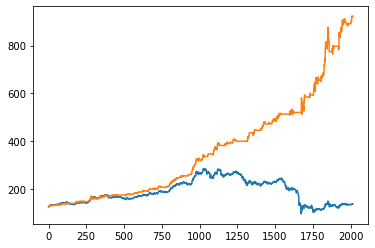

In [41]:
# PPO new - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

500K


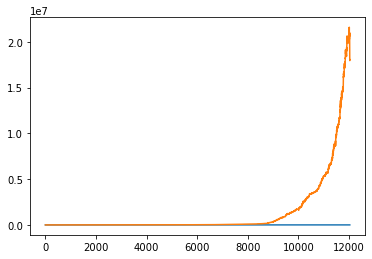

In [42]:
# PPO new
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

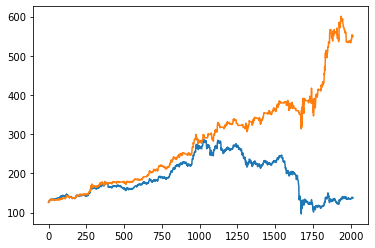

In [36]:
# PPO new
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

500K


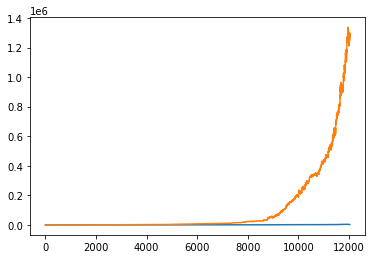

In [35]:
# PPO new
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

500K


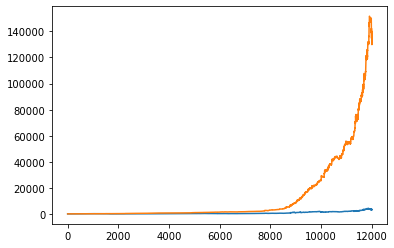

In [152]:
# PPO load
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

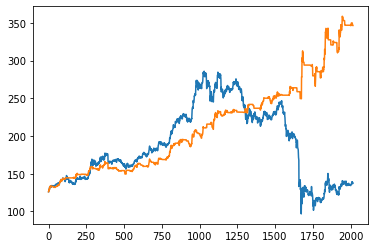

In [153]:
# PPO load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

<AxesSubplot:>

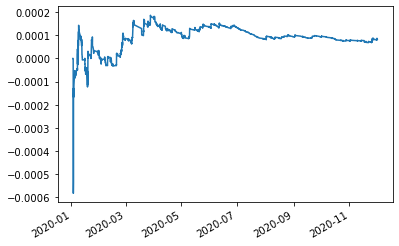

In [133]:
(pd.DataFrame(values_dict).T.value.pct_change() - klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.pct_change()).expanding().mean().plot()

<AxesSubplot:>

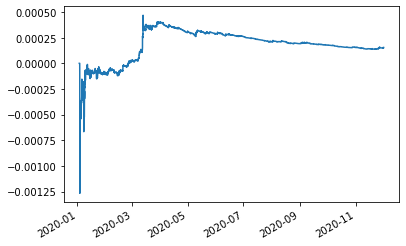

In [194]:
(pd.DataFrame(values_dict).T.value.pct_change() - klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.pct_change()).expanding().mean().plot()

<AxesSubplot:>

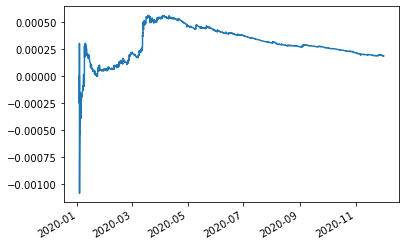

In [220]:
(pd.DataFrame(values_dict).T.value.pct_change() - klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.pct_change()).expanding().mean().plot()

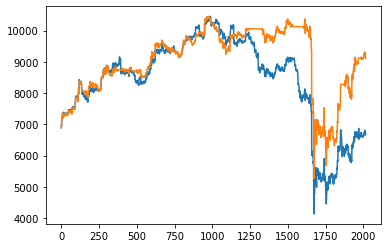

In [129]:
# DQN
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

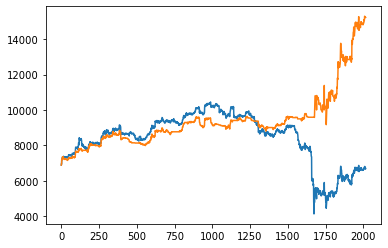

In [195]:
# PPO last
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

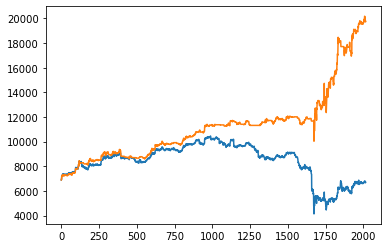

In [221]:
# PPO best
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

250K


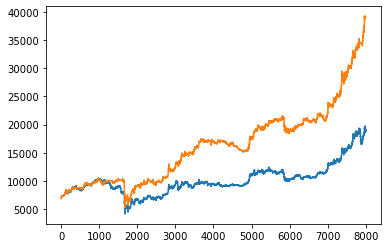

In [112]:
# DQN
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

500K


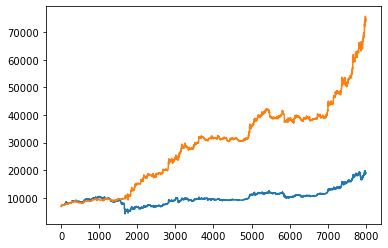

In [196]:
# PPO last
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

500K


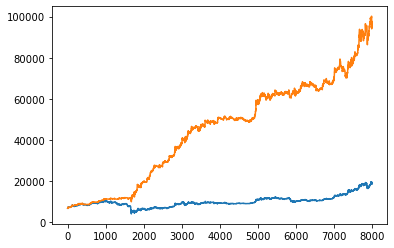

In [222]:
# PPO best
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)